# Objective
- Demonstrate the effect of downsampling and matched cohorts have on outcomes

In [3]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib

import mlflow as ml
import simsurv_func as ssf
# import subprocess
import lifelines
import pytensor.tensor as tt
# import subprocess

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

In [4]:
importlib.reload(ssf)

<module 'simsurv_func' from '/home/twj8/pymc_bart/eval_5_cc/simsurv_func.py'>

# Data Generator

VARS:
- 0 = covid binary 90:10 (0:1)
- 1 = age numeric (0-100) uniform
- 2 = numeric (0-3) uniform
- 3 = numeric (0-1) uniform
- 4 = binary (10:90) (0:1)

- Additonal 5 non contributory variables
- Weak direct effect of COVID but still has noticable mean difference by 360 days
- Weak interaction effect with age

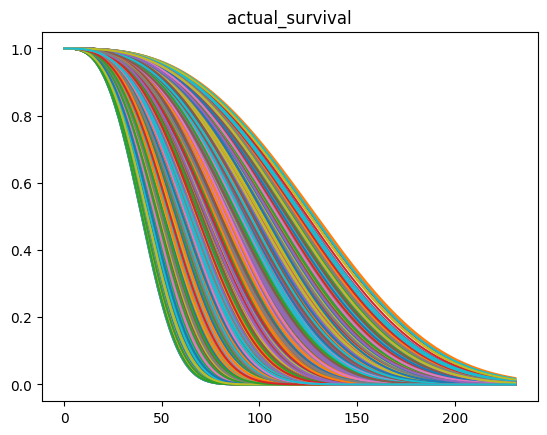

cens_calc: 0.0     
t_mean: 74.00833333333334     
t_max: 231.0


In [3]:
OUTPUTS = "outputs"
ALPHA = 3
ALPHA_F = "3 + .1*x_mat[:,0]"
# ALPHA_F = None
VAR_CLASS = [2,10,3,1,2]
VAR_PROB = [0.5, 0.5, 0.5, 0.5, 0.5]
# friedman 5 dimension function
# LAMBDA = "0.001 * np.exp(3+0.5*np.sin(np.pi*x_mat[:,0]*x_mat[:,1]) + np.power(x_mat[:,2],2) + 0.5*x_mat[:,3] + 0.25*x_mat[:,4])" 
# LAMBDA = "np.exp(-8.4 + 0.2*x_mat[:,0] + 0.2*np.log(x_mat[:,1]) + x_mat[:,0]*0.01*np.log(x_mat[:,1])  + 0.001*np.power(x_mat[:,2],2) + 0.09*(x_mat[:,3]*x_mat[:,4]))" 
# LAMBDA = "np.exp(-2.4 + 0.5*x_mat[:,0] + 0.2*np.log(x_mat[:,1]) + x_mat[:,0]*0.05*np.log(x_mat[:,1])  + 0.01*np.power(x_mat[:,2],2) + 0.5*(x_mat[:,3]*x_mat[:,4]))" 
LAMBDA = "np.exp(-5 + .2*x_mat[:,0] + 0.01*np.log(x_mat[:,1]) + 0.2*(x_mat[:,2] + x_mat[:,3] + x_mat[:,4]))" 

N = 3000
# T = 30
X_VARS = 10
CENS_SCALE = 5# 40
CENS_IND = False
T_CHNG = None

sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = ssf.sim_surv2(
                N=N, 
                x_vars=X_VARS,
                VAR_CLASS= VAR_CLASS,
                VAR_PROB = VAR_PROB,
                a = ALPHA,
                alpha_f=ALPHA_F,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = CENS_IND,
                err_ind = False,
                T_CHNG=T_CHNG)


# Get information of X vars
x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
# calculate censored components
event_calc, cens_calc = ssf.get_status_perc(status) 
# Get the t mean and max
t_mean, t_max = ssf.get_event_time_metric(t_event)
# Get the training matrix
train = ssf.get_train_matrix(x_mat, t_event, status)

# plots moved to kpm by group
title = "actual_survival"
ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True, dir=OUTPUTS)

print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")

### KPM of the FULL TRAIN
The initial function is 

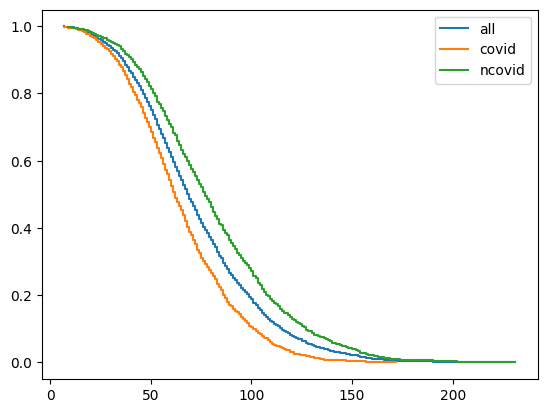

In [4]:
cov_mask = (x_mat[:,0]==1)
y_sk = ssf.get_y_sklearn(status, t_event)

kpm_all = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"], y_sk["Survival_in_days"])
kpm_cov = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][cov_mask], y_sk["Survival_in_days"][cov_mask])
kpm_ncov = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][~cov_mask], y_sk["Survival_in_days"][~cov_mask])
plt.step(kpm_all[0], kpm_all[1], label="all")
plt.step(kpm_cov[0], kpm_cov[1], label="covid")
plt.step(kpm_ncov[0], kpm_ncov[1], label="ncovid")
# plt.xlim(0,400)
plt.legend()

# Transform scale day
- reduce number of computed timepoints

In [5]:
TT_ADJ = 60
TT_SCALE = 10
def get_t_adj(t_event, TT_ADJ, TT_SCALE):
    tt_ind = t_event.copy()
    y_stat = t_event.copy()
    tt_ind[tt_ind>= TT_ADJ] = TT_ADJ
    tt_sc = np.ceil(tt_ind/TT_SCALE)

    y_stat[tt_ind >= TT_ADJ] = 0
    y_stat[tt_ind < TT_ADJ] = 1
    return y_stat, tt_sc


y_stat, tt_sc = get_t_adj(t_event, TT_ADJ=TT_ADJ, TT_SCALE=TT_SCALE)

# Test
# te_y_stat, te_tt_sc = get_t_adj(test_t_event, TT_ADJ=TT_ADJ, TT_SCALE=TT_SCALE)

In [6]:
print(f"{TT_ADJ} day cases")
print(f"covid events {y_stat[cov_mask].sum()}")
print(f"covid cases {y_stat[cov_mask].shape[0]}")
print(f"ncov events {y_stat[~cov_mask].sum()}")
print(f"ncov cases {y_stat[~cov_mask].shape[0]}")

60 day cases
covid events 667.0
covid cases 1513
ncov events 415.0
ncov cases 1487


## Data Prep

In [7]:
# get the event,time and the covariates data
y_sk = ssf.get_y_sklearn(y_stat, tt_sc)
x_sk = train.iloc[:,2:]

## KPM of tranformed

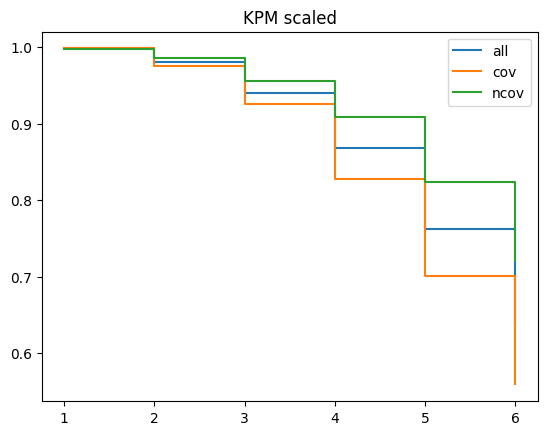

In [8]:
# Full Cohort KPM
cov_mask = (x_mat[:,0]==1)
kpm_adj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"], y_sk["Survival_in_days"])
kpm_cadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][cov_mask], y_sk["Survival_in_days"][cov_mask])
kpm_ncadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][~cov_mask], y_sk["Survival_in_days"][~cov_mask])

plt.step(kpm_adj[0], kpm_adj[1], label="all", where="post")
plt.step(kpm_cadj[0], kpm_cadj[1], label="cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post")
plt.title("KPM scaled")
plt.legend()

# Drop Extra Big Vars

In [9]:
import sys

local_vars = list(locals().items())
vrs = []
for var, obj in local_vars:
    sz = sys.getsizeof(obj)
    if sz > 10000:
        vrs.append((var, sz/10E9))
    # print(var, sys.getsizeof(obj))
vrs

hz_mat = []
# lmbda.shape
te_sv_mat = []

# Case-Cohort
1. sample the full cohort 
2. record sampling percentage
3.

In [10]:
case_mask = (y_sk["Status"] == True)
case_y = y_sk[case_mask]
case_x = x_sk[case_mask]

PRCNT = .05
NSMP = int(N*PRCNT)
sample_mask = np.random.choice(np.arange(0,x_sk.shape[0]), NSMP, replace=False)

sub_x = x_sk.iloc[sample_mask,:]
sub_y = y_sk[sample_mask]

# join cohort
coh_x = pd.concat([case_x, sub_x])
coh_y = np.concatenate([case_y, sub_y])


In [11]:
print(case_x.shape)
print(sub_x.shape)
print(coh_x.shape)

(1082, 10)
(150, 10)
(1232, 10)


In [12]:
# tranform data long-form
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(coh_x, coh_y)
b_te_x = ssf.get_bart_test(coh_x, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))

In [13]:
# get weights
cntrl_msk = np.where(coh_y["Status"]==False)
weight = np.ones(coh_y.shape)
weight[cntrl_msk] = (1/PRCNT)
intl = [x for x in coh_y["Survival_in_days"].tolist()]
www = np.repeat(weight, intl)

# BART


## BART with Weighted LogProb and Posterior Predictive 

In [53]:
import mlflow

In [63]:
# ml_exp = mlflow.create_experiment("test1")
ml_exp = mlflow.get_experiment_by_name("test1")
# mlflow.set_experiment(ml_exp)
ml_exp.experiment_id


'922474634126610090'

In [68]:
mlflow.search_runs(ml_exp.experiment_id)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name
0,8a1d486eecd840b39d5d77bbea076298,922474634126610090,FINISHED,file:///home/twj8/pymc_bart/eval_5_cc/mlruns/9...,2023-10-13 17:07:05.846000+00:00,2023-10-13 17:07:05.909000+00:00,1.0,LOCAL,twj8,test1,/home/twj8/.local/lib/python3.10/site-packages...


In [67]:
mlflow.start_run(run_name="test1", experiment_id=ml_exp.experiment_id)
mlflow.log_metric("test", 1)
mlflow.end_run()

In [14]:
# BART
M = 20 # number of trees
DRAWS = 100
TUNE = 100
CORES = 1
SPLIT_RULES = [
    pmb.ContinuousSplitRule(),
    pmb.OneHotSplitRule,
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.OneHotSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule()
]

# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)


with pm.Model() as bart:    
    x_data = pm.MutableData("x", b_tr_x)
    weight = pm.MutableData("w", www)
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = SPLIT_RULES)
    z = pm.Deterministic("z", (f + off))
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    # y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])    # old
    # y_pred = pm.Potential("y_pred", weight * pm.logp(pm.Bernoulli.dist(p=mu), b_tr_delta))
    y_pred = pm.CustomDist("y_pred", mu, weight, dist=dist_bern, logp=logp_bern, observed=b_tr_delta, shape = x_data.shape[0])
    # bdata = pm.sample(100, cores=2)
    bdata = pm.sample(draws=DRAWS, tune=TUNE, cores=4, compute_convergence_checks=False)

with pm.Model() as bart2:    
    x_data = pm.MutableData("x", b_tr_x)
    weight = pm.MutableData("w", www)
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = SPLIT_RULES)
    z = pm.Deterministic("z", (f + off))
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    # y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])    # old
    # y_pred = pm.Potential("y_pred", weight * pm.logp(pm.Bernoulli.dist(p=mu), b_tr_delta))
    y_pred = pm.CustomDist("y_pred", mu, weight, dist=dist_bern, logp=logp_bern, observed=b_tr_delta, shape = x_data.shape[0])
    # bdata = pm.sample(100, cores=2)

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 14 seconds.


In [540]:
# bdata.to_netcdf("bdata.nc")
# bdata2 = az.from_netcdf("bdata.nc")

In [11]:
with bart:
    # pm.set_data({"x_data": np.array(b_te_x)}, coords=np.arange(0,b_te_x.shape[0]))
    pm.set_data({"x":np.array(b_te_x)}, coords= {"obs":np.arange(0, b_te_x.shape[0],1)})
    post2 = pm.sample_posterior_predictive(bdata, var_names=["mu"])

post2

NameError: name 'bart' is not defined

In [542]:
with bart2:
    # pm.set_data({"x_data": np.array(b_te_x)}, coords=np.arange(0,b_te_x.shape[0]))
    pm.set_data({"x":np.array(b_te_x)}, coords= {"obs":np.arange(0, b_te_x.shape[0],1)})
    post3 = pm.sample_posterior_predictive(bdata2, var_names=["mu"])

post3

Sampling: [f]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [8]:
import cloudpickle as cpkl

In [12]:
importlib.reload(ssf)

<module 'simsurv_func' from '/home/twj8/pymc_bart/eval_5_cc/simsurv_func.py'>

In [13]:
bbb = ssf.get_files("test2.pkl")

EOFError: Ran out of input

In [14]:
# with open('test2.pkl', mode='wb') as file:
#    cpkl.dump({"model":bart, "trace":bdata}, file)


with open('test1.pkl', mode='rb') as file:
   bart4 = cpkl.load(file)

AuthenticationError: digest sent was rejected

: 

In [25]:
bart4=[]

In [40]:
import threading
for thread in threading.enumerate(): 
    print(thread.name)

threading.active_count()

MainThread
IOPub
Heartbeat
Thread-2 (_watch_pipe_fd)
Thread-3 (_watch_pipe_fd)
Control
IPythonHistorySavingThread
Thread-4


8

In [24]:
with bart4["model"]:
    # bart4.mu.eval()
    pm.set_data({"x":np.array(b_te_x)}, coords= {"obs":np.arange(0, b_te_x.shape[0],1)})
    post4 = pm.sample_posterior_predictive(bdata, var_names=["mu"])


Sampling: [f]


FileNotFoundError: [Errno 2] No such file or directory
Apply node that caused the error: BART_rv{1, (2, 1, 0, 0, 0, 1), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FB88F1D5000>), [], 11, x, [0. 0. 0. ... 0. 0. 1.], 20, 0.95, 2.0, [])
Toposort index: 0
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(0,)), TensorType(int64, shape=()), TensorType(float64, shape=(None, None)), TensorType(float64, shape=(5962,)), TensorType(int8, shape=()), TensorType(float64, shape=()), TensorType(float32, shape=()), TensorType(float64, shape=(0,))]
Inputs shapes: ['No shapes', (0,), (), (7392, 11), (5962,), (), (), (), (0,)]
Inputs strides: ['No strides', (8,), (), (88, 8), (8,), (), (), (), (8,)]
Inputs values: [Generator(PCG64) at 0x7FB88F1D5000, array([], dtype=int64), array(11), 'not shown', 'not shown', array(20, dtype=int8), array(0.95), array(2., dtype=float32), array([], dtype=float64)]
Outputs clients: [['output'], [Composite{(0.5 * erfc((-0.7071067932881648 * (i0 - 0.8685274181096769))))}(f)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [22]:
bart4["model"].mu.eval()

FileNotFoundError: [Errno 2] No such file or directory
Apply node that caused the error: BART_rv{1, (2, 1, 0, 0, 0, 1), floatX, False}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FB86189E6C0>), [], 11, x, [0. 0. 0. ... 0. 0. 1.], 20, 0.95, 2.0, [])
Toposort index: 0
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(0,)), TensorType(int64, shape=()), TensorType(float64, shape=(None, None)), TensorType(float64, shape=(5962,)), TensorType(int8, shape=()), TensorType(float64, shape=()), TensorType(float32, shape=()), TensorType(float64, shape=(0,))]
Inputs shapes: ['No shapes', (0,), (), (5962, 11), (5962,), (), (), (), (0,)]
Inputs strides: ['No strides', (8,), (), (88, 8), (8,), (), (), (), (8,)]
Inputs values: [Generator(PCG64) at 0x7FB86189E6C0, array([], dtype=int64), array(11), 'not shown', 'not shown', array(20, dtype=int8), array(0.95), array(2., dtype=float32), array([], dtype=float64)]
Outputs clients: [[], [Composite{(0.5 * erfc((-0.7071067932881648 * (i0 - 0.8685274181096769))))}(f)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/home/twj8/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/twj8/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/twj8/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_19504/1134111782.py", line 31, in <module>
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = SPLIT_RULES)
  File "/home/twj8/.local/lib/python3.10/site-packages/pymc_bart/bart.py", line 175, in __new__
    return super().__new__(cls, name, *params, **kwargs)
  File "/home/twj8/.local/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 314, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/home/twj8/.local/lib/python3.10/site-packages/pymc_bart/bart.py", line 179, in dist
    return super().dist(params, **kwargs)
  File "/home/twj8/.local/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 393, in dist
    rv_out = cls.rv_op(*dist_params, size=create_size, **kwargs)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [26]:
# bart4.mu.owner
pmb.predict(

AttributeError: module 'pymc_bart' has no attribute 'predict'

In [20]:
with bart4:
    # bart4.mu.eval()
    pm.set_data({"x":np.array(b_te_x)}, coords= {"obs":np.arange(0, b_te_x.shape[0],1)})
    # post4 = pm.sample_posterior_predictive(bdata, var_names=["mu"])


FileNotFoundError: [Errno 2] No such file or directory
Apply node that caused the error: BART_rv{1, (2, 1, 0, 0, 0, 1), floatX, False}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F8C7527D620>), [], 11, x, [0. 0. 1. ... 0. 0. 1.], 20, 0.95, 2.0, [])
Toposort index: 0
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(0,)), TensorType(int64, shape=()), TensorType(float64, shape=(None, None)), TensorType(float64, shape=(5857,)), TensorType(int8, shape=()), TensorType(float64, shape=()), TensorType(float32, shape=()), TensorType(float64, shape=(0,))]
Inputs shapes: ['No shapes', (0,), (), (7398, 11), (5857,), (), (), (), (0,)]
Inputs strides: ['No strides', (8,), (), (88, 8), (8,), (), (), (), (8,)]
Inputs values: [Generator(PCG64) at 0x7F8C7527D620, array([], dtype=int64), array(11), 'not shown', 'not shown', array(20, dtype=int8), array(0.95), array(2., dtype=float32), array([], dtype=float64)]
Outputs clients: [[], [Composite{(0.5 * erfc((-0.7071067932881648 * (i0 - 0.8553615316582451))))}(f)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/home/twj8/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/twj8/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/twj8/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_19249/1134111782.py", line 31, in <module>
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = SPLIT_RULES)
  File "/home/twj8/.local/lib/python3.10/site-packages/pymc_bart/bart.py", line 175, in __new__
    return super().__new__(cls, name, *params, **kwargs)
  File "/home/twj8/.local/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 314, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/home/twj8/.local/lib/python3.10/site-packages/pymc_bart/bart.py", line 179, in dist
    return super().dist(params, **kwargs)
  File "/home/twj8/.local/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 393, in dist
    rv_out = cls.rv_op(*dist_params, size=create_size, **kwargs)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [537]:
post2

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [455]:
with bart:
    # pm.set_data({"x_data": np.array(b_te_x)}, coords=np.arange(0,b_te_x.shape[0]))
    pm.set_data({"x":np.array(b_te_x)}, coords= {"obs":np.arange(0, b_te_x.shape[0],1)})
    post = pm.sample_posterior_predictive(bdata, var_names=["mu"])

Sampling: [f]


In [531]:
post

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [457]:
with bart:
    pm.set_data({"x":np.array(b_te_x)})
    post2 = pm.sample_posterior_predictive(bdata, var_names=["mu"])

Sampling: [f]


In [458]:
post2

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [148]:
from importlib import reload

In [149]:
import cc_6_bart_model_builder as bmb

In [466]:
importlib.reload(bmb)

model_dict = {"trees": 20,
    "split_rules": [
    "pmb.ContinuousSplitRule()",
    "pmb.OneHotSplitRule",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.OneHotSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()",
    "pmb.ContinuousSplitRule()"
    ]
}

bart_model = bmb.BartSurvModel(model_config=model_dict)

In [481]:
bart_model.fit(b_tr_x, b_tr_delta, www, predictor_names=["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10"])

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
PGBART: [f]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 8 seconds.
Sampling: []


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data
	> fit_data
	> predictor_names

In [487]:
b_te_x2 = np.array(np.vstack([b_te_x,b_te_x]))

In [488]:
bart_model.sample_posterior_predictive(np.array(b_te_x2), extend_idata=False, combined=False)
# bart_model.is_fitted_

Sampling: [f]


(7218, 11)
(14436, 11)


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [489]:
bart_model.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data
	> fit_data
	> predictor_names

In [490]:
bart_model.save("bart1.nc")

In [503]:
importlib.reload(bmb)

bart_model2 = bmb.BartSurvModel().load("bart1.nc")
# bart_model.save("bart1.nc")

NO DEFAULT MODEL CONFIGS, MUST SPECIFY


/home/twj8/.local/lib/python3.10/site-packages/arviz/data/inference_data.py:152: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/home/twj8/.local/lib/python3.10/site-packages/arviz/data/inference_data.py:152: UserWarning: predictor_names group is not defined in the InferenceData scheme
  warnings.warn(


In [523]:
bart_model.idata.posterior["mu"]

<xarray.DataArray 'mu' (chain: 2, draw: 100, mu_dim_0: 5785)>
array([[[0.03281162, 0.03281162, 0.03281162, ..., 0.03318033,
         0.08996424, 0.09672358],
        [0.01977472, 0.01466038, 0.02254236, ..., 0.02817062,
         0.07877165, 0.08489856],
        [0.01873555, 0.01385681, 0.02138071, ..., 0.02988511,
         0.08264766, 0.08899752],
        ...,
        [0.00495635, 0.00881572, 0.02475706, ..., 0.02678544,
         0.08821292, 0.08061556],
        [0.00414493, 0.00745745, 0.02141788, ..., 0.02749208,
         0.07506064, 0.07651374],
        [0.00261899, 0.00484878, 0.00664033, ..., 0.01771835,
         0.05224828, 0.05334507]],

       [[0.03027263, 0.03027263, 0.10553175, ..., 0.02980367,
         0.02980367, 0.01671657],
        [0.04116049, 0.04116049, 0.13323688, ..., 0.01045964,
         0.01045964, 0.02166333],
        [0.08075156, 0.08075156, 0.17593662, ..., 0.01908658,
         0.01908658, 0.03720375],
        ...,
        [0.00314625, 0.04748098, 0.04748098, ..., 0.03472566,
         0.05205483, 0.05205483],
        [0.0078068 , 0.0493749 , 0.0493749 , ..., 0.03379693,
         0.05076504, 0.05076504],
        [0.01196213, 0.06791986, 0.06791986, ..., 0.04763565,
         0.06515192, 0.06515192]]])
Coordinates:
  * chain     (chain) int64 0 1
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 ... 5779 5780 5781 5782 5783 5784

In [522]:
bart_model2.idata.posterior["mu"]

<xarray.DataArray 'mu' (chain: 2, draw: 100, mu_dim_0: 5785)>
[1157000 values with dtype=float64]
Coordinates:
  * chain     (chain) int64 0 1
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 ... 5779 5780 5781 5782 5783 5784

In [508]:
bart_model2.model.eval_rv_shapes()

{'f': (5785,)}

In [496]:
bart_model2.model.x_data.eval().shape

(5785, 11)

In [411]:
b_te_x.shape

(7218, 11)

In [413]:
bart_model2.model.mu

mu ~ Deterministic(f(f))

In [509]:
bart_model2.sample_posterior_predictive(np.array(b_te_x), extend_idata=False, combined=True)

(5785, 11)
(7218, 11)


Sampling: [f]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [524]:
idf = az.InferenceData.from_netcdf("bart1.nc")
X = np.array(b_tr_x)
y = b_tr_delta
weights = www

with pm.Model() as model2:    
            x_data = pm.MutableData("x_data", X)
            w = pm.MutableData("weights", weights)
            # change names of y_values
            f = pmb.BART("f", X=x_data, Y=y.flatten(), m=M, split_rules = SPLIT_RULES)
            z = pm.Deterministic("z", (f + off))
            mu = pm.Deterministic("mu", pm.math.invprobit(z))
            pm.CustomDist("y_pred", mu, w.flatten(), dist=dist_bern, logp=logp_bern, observed=y.flatten(), shape = x_data.shape[0])            
    

/home/twj8/.local/lib/python3.10/site-packages/arviz/data/inference_data.py:152: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/home/twj8/.local/lib/python3.10/site-packages/arviz/data/inference_data.py:152: UserWarning: predictor_names group is not defined in the InferenceData scheme
  warnings.warn(


In [525]:
with model2:
    pm.set_data({"x_data":np.array(b_te_x)}, coords={"obs":np.arange(0,b_te_x.shape[0])})
    print(model2["x_data"].eval().shape)
    db = pm.sample_posterior_predictive(idf, var_names=["mu"], model=model2)

db

(7218, 11)


Sampling: [f]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [530]:

idf

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data
	> fit_data
	> predictor_names

In [528]:
# bart_model2.idata.posterior_predictive["mu"].values.shape
# bart_model2.y.shape
bart_model2.model.named_vars

{'x_data': x_data,
 'weights': weights,
 'f': f ~ BART(<shared>, <constant>, 20, 0.95, 2, <constant>),
 'z': z ~ Deterministic(f(f)),
 'mu': mu ~ Deterministic(f(f)),
 'y_pred': y_pred ~ CustomSymbolicDist(f(), mu, f())}

/home/twj8/.local/lib/python3.10/site-packages/arviz/data/inference_data.py:152: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/home/twj8/.local/lib/python3.10/site-packages/arviz/data/inference_data.py:152: UserWarning: predictor_names group is not defined in the InferenceData scheme
  warnings.warn(


In [434]:
with bart_model2.model:
    pm.set_data({"x_data": np.array(b_te_x)})
    post = pm.sample_posterior_predictive(idf, var_names=["mu"])

Sampling: [f]


In [441]:
bart_model2.model.x_data.eval().shape

(7218, 11)

In [448]:
with bart_model2.model:
    # pm.set_data({"x_data": np.array(b_te_x)}, coords=np.arange(0,b_te_x.shape[0]))
    pm.set_data({"x_data":pd.DataFrame(b_te_x)}, coords= {"obs":np.arange(0, b_te_x.shape[0],1)})
    post = pm.sample_posterior_predictive(idf, var_names=["mu"])

Sampling: [f]


In [449]:
post

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [341]:
zzzz = np.hstack([b_tr_delta.reshape(b_tr_delta.shape[0],1), b_tr_x])
xr.DataArray(zzzz)


<xarray.DataArray (dim_0: 5785, dim_1: 12)>
array([[0.        , 1.        , 0.        , ..., 0.9664907 , 0.87857388,
        0.68038185],
       [0.        , 2.        , 0.        , ..., 0.9664907 , 0.87857388,
        0.68038185],
       [0.        , 3.        , 0.        , ..., 0.9664907 , 0.87857388,
        0.68038185],
       ...,
       [0.        , 4.        , 0.        , ..., 0.63607585, 0.61680625,
        0.29644918],
       [0.        , 5.        , 0.        , ..., 0.63607585, 0.61680625,
        0.29644918],
       [1.        , 6.        , 0.        , ..., 0.63607585, 0.61680625,
        0.29644918]])
Dimensions without coordinates: dim_0, dim_1

In [499]:
def get_sv_fx(pp, r0, r1):
    p0 = pp.posterior_predictive["mu"].values.shape[0]
    p1 = pp.posterior_predictive["mu"].values.shape[1]
    p2 = pp.posterior_predictive["mu"].values.shape[2]
    pp_post = pp.posterior_predictive["mu"].values.reshape(p0*p1, p2).mean(axis=0).reshape(r0, r1)
    sv = (1-pp_post).cumprod(axis=1)
    return sv

In [500]:
# transform to survival
# fill times
smp_t_shp= np.unique(coh_y["Survival_in_days"]).shape[0]
smp_shp = coh_y.shape[0]

t_min = np.unique(b_tr_t).min()
t_fill = np.arange(t_min)
val_fill = np.ones(t_fill.shape)
npat = coh_y.shape[0]
val_fill = np.repeat(val_fill, npat).reshape(npat,val_fill.shape[0])

bart_sv_fx = get_sv_fx(pp, smp_shp,5)
bart_sv_val = np.hstack([val_fill, bart_sv_fx])

bart_sv_t = np.unique(b_tr_t)
bart_sv_t = np.hstack([t_fill, bart_sv_t])

## Posterior Predictive Plot
- posterior predictive check on training samples

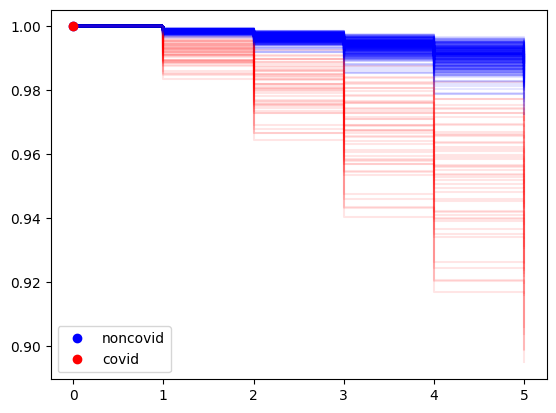

In [501]:
# Plot the posterior predictions
for r in np.arange(0, bart_sv_val.shape[0]):
    if coh_cov_msk[r] == 1:
        col = "red"
        lab="covid"
    else:
        col = "blue"
        lab="noncovid"
    plt.step(bart_sv_t, bart_sv_val[r,:], alpha=0.1, color=col, where="post")
plt.plot(0,1, "bo", label="noncovid")
plt.plot(0,1, "ro", label="covid")

plt.legend()

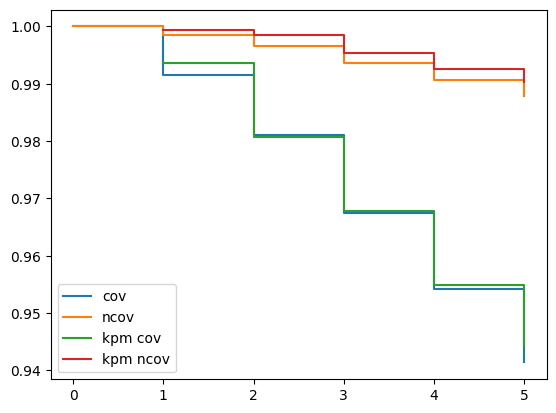

In [502]:
full_cov_mask = (x_mat[:,0]==1)
# kpm_adj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"], y_sk["Survival_in_days"])
kpm_cadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][full_cov_mask], y_sk["Survival_in_days"][full_cov_mask])
kpm_ncadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][~full_cov_mask], y_sk["Survival_in_days"][~full_cov_mask])

plt.step(bart_sv_t, bart_sv_val[coh_cov_msk].mean(0), label="cov", where="post")
plt.step(bart_sv_t, bart_sv_val[~coh_cov_msk].mean(0), label="ncov", where="post")
# plt.step(kpm_adj[0], kpm_adj[1], label="all", where="post")
plt.step(kpm_cadj[0], kpm_cadj[1], label="kpm cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="kpm ncov", where="post")


plt.legend()


The posterior predictions do a good job of estimating the SV probability in comparison to the Full KPM

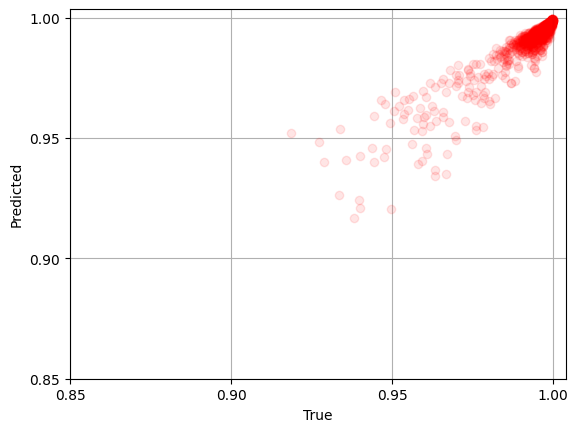

In [503]:
# sample_mask.shape
t_msk = np.array(np.arange(0,np.ceil(TT_ADJ/TT_SCALE) + 1) * TT_SCALE, dtype="int")
sv_true_t = sv_mat[:,t_msk]
sv_true_t1 = sv_true_t[case_mask,:]
sv_true_t2 = sv_true_t[sample_mask,:]
sv_true_t = np.vstack([sv_true_t1, sv_true_t2])
t_len = len(t_msk)

assert sv_true_t.shape ==  bart_sv_val.shape

for i in np.arange(0,sv_true_t.shape[0]):
    plt.plot(sv_true_t[i,1:-1],bart_sv_val[i,1:-1],"ro", alpha=0.1)
plt.ylabel("Predicted")
plt.xlabel("True")
plt.xticks(np.arange(0.85,1, 0.05))
plt.yticks(np.arange(0.85,1, 0.05))
plt.grid(visible="true")



The TRUE=PRED plot displays a good relationship between the TRUE and Pred values. There is some bias in the predictions, but the variance is not massive and the predictions appear fairly centered on the 1:1 line

In [504]:
shp1,shp2,shp3 = pp.posterior_predictive["mu"].values.shape
shp4 = coh_x.shape[0]
shp5 = np.unique(b_tr_t).shape[0]

bart_hz1 = pp.posterior_predictive["mu"].values.reshape(shp1*shp2, shp3).mean(axis=0).reshape(shp4,shp5)
bart_chz1 = np.cumsum(bart_hz1, axis=1)

for i in np.arange(bart_hz1.shape[1]):
    ci = concordance_index_censored(coh_y["Status"], coh_y["Survival_in_days"], bart_hz1[:,i])
    print(f"bart cindex {i}: {ci}")


bart cindex 0: (0.7899088509239428, 15859, 4218, 0, 3952)
bart cindex 1: (0.7872690142949644, 15806, 4271, 0, 3952)
bart cindex 2: (0.7867958360312796, 15796, 4280, 1, 3952)
bart cindex 3: (0.7864969866015838, 15790, 4286, 1, 3952)
bart cindex 4: (0.7848284106191165, 15757, 4320, 0, 3952)


## Test Case:Cohort 

In [505]:
with bart:
    pm.set_data({"x":pd.DataFrame(te_b_te_x)}, coords= {"obs":np.arange(0,te_b_te_x.shape[0],1)})
    te_pp = pm.sample_posterior_predictive(bdata, var_names=["mu"])

Sampling: [f]


In [506]:
def get_sv_wrap(coh_y, b_tr_t, pp):
    smp_t_shp= np.unique(coh_y["Survival_in_days"]).shape[0]
    smp_shp = coh_y.shape[0]

    t_min = np.unique(b_tr_t).min()
    t_fill = np.arange(t_min)
    val_fill = np.ones(t_fill.shape)
    npat = coh_y.shape[0]
    val_fill = np.repeat(val_fill, npat).reshape(npat,val_fill.shape[0])

    bart_sv_fx = get_sv_fx(pp, smp_shp,smp_t_shp)
    bart_sv_val = np.hstack([val_fill, bart_sv_fx])

    bart_sv_t = np.unique(b_tr_t)
    bart_sv_t = np.hstack([t_fill, bart_sv_t])
    return bart_sv_val, bart_sv_t

te_bart_sv_val, te_bart_sv_t = get_sv_wrap(te_y_sk, te_b_tr_t, te_pp)

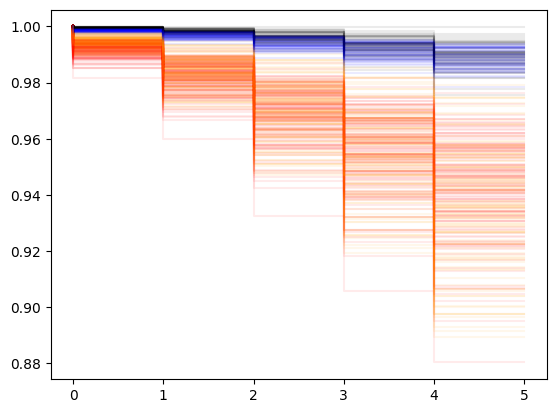

In [507]:
te_cov_msk = np.array(te_x_sk.iloc[:,0]==1)
for i in np.arange(0, te_bart_sv_val.shape[0]):
    if te_cov_msk[i]:
        col="red"
        col2 = "orange"
    else:
        col = "blue"
        col2 = "black"
    plt.step(te_bart_sv_t, te_bart_sv_val[i,:], color=col, alpha=0.08)
    plt.step(te_bart_sv_t, te_sv_f[i,:], color=col2, alpha=0.08)

In [508]:
p_c95 = np.quantile(te_bart_sv_val[te_cov_mask,:], [0.0275,0.975], axis=0)
p_nc95 = np.quantile(te_bart_sv_val[~te_cov_mask,:], [0.0275,0.975], axis=0)
t_c95 = np.quantile(te_sv_f[te_cov_mask,:], [0.0275,0.975], axis=0)
t_nc95 = np.quantile(te_sv_f[~te_cov_mask,:], [0.0275,0.975], axis=0)

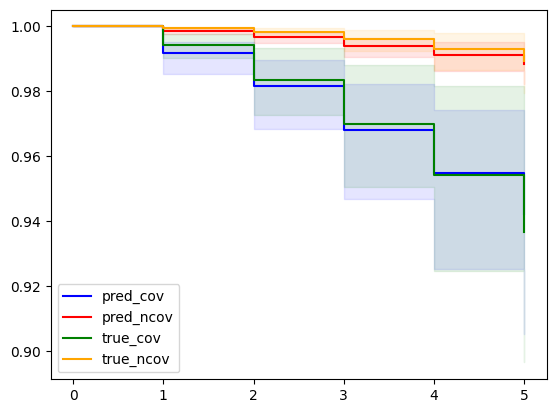

In [509]:
te_cov_msk = np.array(te_x_sk.iloc[:,0]==1)
plt.step(te_bart_sv_t, te_bart_sv_val[te_cov_msk,:].mean(0), label = "pred_cov", where="post", color="blue")
plt.fill_between(te_bart_sv_t, y1=p_c95[0,:], y2 = p_c95[1,:], step="post", alpha=0.1, color="blue")

plt.step(te_bart_sv_t, te_bart_sv_val[~te_cov_msk,:].mean(0), label = "pred_ncov", color="red", where="post")
plt.fill_between(te_bart_sv_t, y1=p_nc95[0,:], y2 = p_nc95[1,:], step="post", alpha=0.1, color="red")

plt.step(te_bart_sv_t, te_sv_f[te_cov_msk,:].mean(0), label = "true_cov", color="green", where="post")
plt.fill_between(te_bart_sv_t, y1=t_c95[0,:], y2 = t_c95[1,:], step="post", alpha=0.1, color="green")

plt.step(te_bart_sv_t, te_sv_f[~te_cov_msk,:].mean(0), label = "true_ncov", color="orange", where="post")
plt.fill_between(te_bart_sv_t, y1=t_nc95[0,:], y2 = t_nc95[1,:], step="post", alpha=0.1, color="orange")
plt.legend()

The predictive mean aligns well with the true values. 
The 95% interval is broader of the predictions than the true 95% interval. However this may be resolved with increased sampling. Current sample size is fairly small.

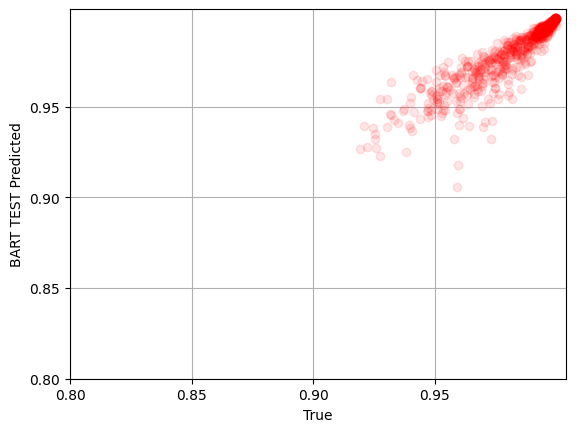

In [510]:
for i in np.arange(0,te_sv_f.shape[0]):
    plt.plot(te_sv_f[i,1:-1],te_bart_sv_val[i, 1:-1], "ro", alpha=0.1)
    # plt.plot(bart_sv_val[i,1:-1], cph_sv_val[i,1:-1],"bo", alpha=0.1)

plt.ylabel("BART TEST Predicted")
plt.xlabel("True")
plt.xticks(np.arange(0.80,1, 0.05))
plt.yticks(np.arange(0.80,1, 0.05))
plt.grid(visible=True)

The True=Pred plot demonstrates a good relationshipt between the Predicted and Expeted valeus.

## COX Train Full and Predict on Test

In [ ]:
cph = sks.linear_model.CoxPHSurvivalAnalysis().fit(x_sk, y_sk)
print(f"exp coef: {np.exp(cph.coef_)}")

cph_sv = cph.predict_survival_function(te_x_sk)
cph_sv = np.array([fx(fx.x) for fx in cph_sv])

# we can reuse val_fill from above
cph_val_fill = np.repeat(0,cph_sv.shape[0]).reshape((cph_sv.shape[0],1))
cph_sv_val = np.hstack([cph_val_fill, cph_sv])

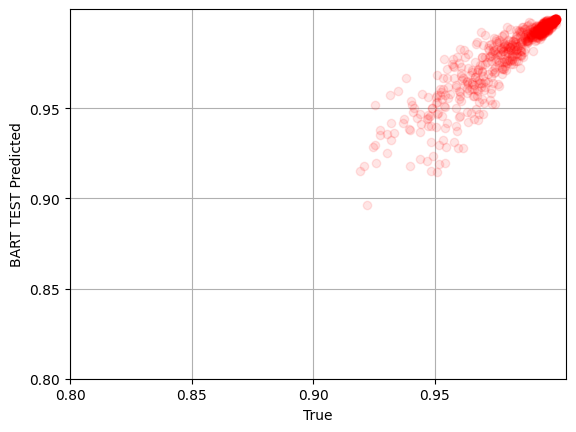

In [511]:
for i in np.arange(0,te_sv_f.shape[0]):
    plt.plot(te_sv_f[i,1:-1],cph_sv_val[i, 1:-1], "ro", alpha=0.1)
    # plt.plot(bart_sv_val[i,1:-1], cph_sv_val[i,1:-1],"bo", alpha=0.1)

plt.ylabel("BART TEST Predicted")
plt.xlabel("True")
plt.xticks(np.arange(0.80,1, 0.05))
plt.yticks(np.arange(0.80,1, 0.05))
plt.grid(visible=True)

## C-index

In [512]:
shp1,shp2,shp3 = te_pp.posterior_predictive["mu"].values.shape
shp4 = te_x_sk.shape[0]
shp5 = np.unique(te_b_tr_t).shape[0]

bart_hz1 = te_pp.posterior_predictive["mu"].values.reshape(shp1*shp2, shp3).mean(axis=0).reshape(shp4,shp5)
bart_chz1 = np.cumsum(bart_hz1, axis=1)
cph_chz = cph.predict_cumulative_hazard_function(te_x_sk)
cph_chz = np.array([fn(fn.x) for fn in cph_chz])

for i in np.arange(bart_hz1.shape[1]):
    ci = concordance_index_censored(te_y_sk["Status"], te_y_sk["Survival_in_days"], bart_hz1[:,i])
    print(f"bart cindex {i}: {ci}")

for i in np.arange(cph_chz.shape[1]):
    ci = concordance_index_censored(te_y_sk["Status"], te_y_sk["Survival_in_days"], cph_chz[:,i])
    print(f"cph cindex {i}: {ci}")


bart cindex 0: (0.6648205346682288, 6242, 3147, 0, 2000)
bart cindex 1: (0.6664181488976462, 6257, 3132, 0, 2000)
bart cindex 2: (0.6686548088188305, 6278, 3111, 0, 2000)
bart cindex 3: (0.6671637022047077, 6264, 3125, 0, 2000)
bart cindex 4: (0.6676962402811801, 6269, 3120, 0, 2000)
cph cindex 0: (0.6722760677388433, 6312, 3077, 0, 2000)
cph cindex 1: (0.6722760677388433, 6312, 3077, 0, 2000)
cph cindex 2: (0.6722760677388433, 6312, 3077, 0, 2000)
cph cindex 3: (0.6722760677388433, 6312, 3077, 0, 2000)
cph cindex 4: (0.6722760677388433, 6312, 3077, 0, 2000)


## Random Sample
- Test how a random sample to similar size performs

In [195]:
smpl_size = coh_y.shape[0]
full_size = x_sk.shape[0]
smp_msk = np.random.choice(np.arange(0, full_size), smpl_size, replace = False)
smp_x = x_sk.iloc[smp_msk,:]
smp_y = y_sk[smp_msk]

In [211]:
smp_cov_msk = smp_x.to_numpy()[:,0] == 1
smp_y_st = smp_y["Status"]
print(f"{smpl_size} obs")
print(f"covid events {smp_y_st[smp_cov_msk].sum()}")
print(f"covid cases {smp_y[smp_cov_msk].shape[0]}")
print(f"ncov events {smp_y_st[~smp_cov_msk].sum()}")
print(f"ncov cases {smp_y[~smp_cov_msk].shape[0]}")

320 obs
covid events 2
covid cases 27
ncov events 2
ncov cases 293


Initially we can see there are very few events

In [212]:
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(coh_x, coh_y)
b_te_x = ssf.get_bart_test(coh_x, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))

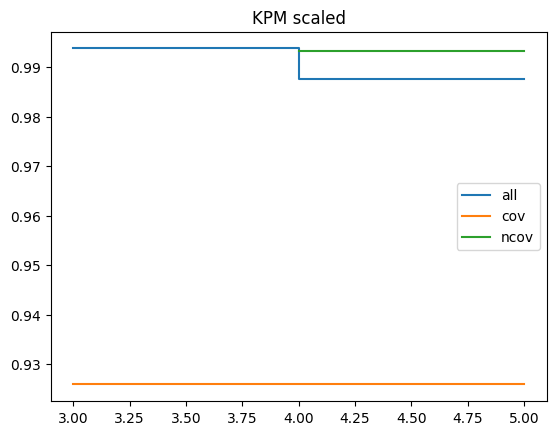

In [213]:
cov_mask = (x_mat[:,0]==1)
kpm_adj = sks.nonparametric.kaplan_meier_estimator(smp_y["Status"], smp_y["Survival_in_days"])
kpm_cadj = sks.nonparametric.kaplan_meier_estimator(smp_y["Status"][smp_cov_msk], smp_y["Survival_in_days"][smp_cov_msk])
kpm_ncadj = sks.nonparametric.kaplan_meier_estimator(smp_y["Status"][~smp_cov_msk], smp_y["Survival_in_days"][~smp_cov_msk])

plt.step(kpm_adj[0], kpm_adj[1], label="all", where="post")
plt.step(kpm_cadj[0], kpm_cadj[1], label="cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post")
plt.title("KPM scaled")
plt.legend()

Based on the KPM we can see that a random sample down to the size of the case-cohort does a terrible job of return an approximated KPM to the full dataset

## Sample with a larger dataset
- 5x the case-cohort size

In [513]:
smpl_size = int(coh_y.shape[0] * 5)
full_size = x_sk.shape[0]
smp_msk = np.random.choice(np.arange(0, full_size), smpl_size, replace = False)
smp_x = x_sk.iloc[smp_msk,:]
smp_y = y_sk[smp_msk]

smp_cov_msk = smp_x.to_numpy()[:,0] == 1
smp_y_st = smp_y["Status"]
print(f"{smpl_size} obs")
print(f"covid events {smp_y_st[smp_cov_msk].sum()}")
print(f"covid cases {smp_y[smp_cov_msk].shape[0]}")
print(f"ncov events {smp_y_st[~smp_cov_msk].sum()}")
print(f"ncov cases {smp_y[~smp_cov_msk].shape[0]}")

1600 obs
covid events 9
covid cases 163
ncov events 15
ncov cases 1437


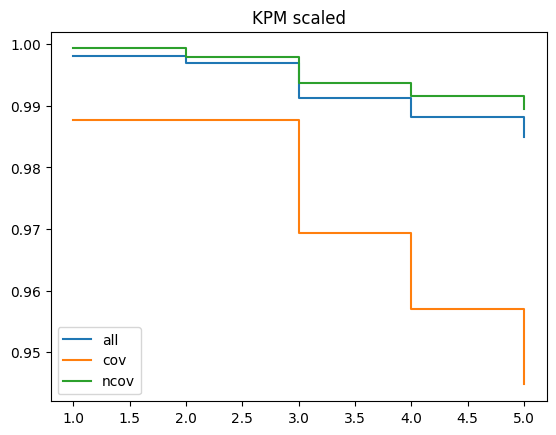

In [514]:

# KPM
cov_mask = (x_mat[:,0]==1)
kpm_adj = sks.nonparametric.kaplan_meier_estimator(smp_y["Status"], smp_y["Survival_in_days"])
kpm_cadj = sks.nonparametric.kaplan_meier_estimator(smp_y["Status"][smp_cov_msk], smp_y["Survival_in_days"][smp_cov_msk])
kpm_ncadj = sks.nonparametric.kaplan_meier_estimator(smp_y["Status"][~smp_cov_msk], smp_y["Survival_in_days"][~smp_cov_msk])

plt.step(kpm_adj[0], kpm_adj[1], label="all", where="post")
plt.step(kpm_cadj[0], kpm_cadj[1], label="cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post")
plt.title("KPM scaled")
plt.legend()

With 5x the samples we start to approximate the full kpm

In [515]:
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(smp_x, smp_y)
b_te_x = ssf.get_bart_test(smp_x, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))

M = 20 # number of trees
DRAWS = 100
TUNE = 100
CORES = 1
SPLIT_RULES = [
    pmb.ContinuousSplitRule(),
    pmb.OneHotSplitRule,
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.OneHotSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule()
]

# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)


with pm.Model() as bart:    
    x_data = pm.MutableData("x", b_tr_x)
    weight = pm.MutableData("w", www)
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = SPLIT_RULES)
    z = pm.Deterministic("z", (f + off))
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])    # use classic bernoulli
    # y_pred = pm.Potential("y_pred", weight * pm.logp(pm.Bernoulli.dist(p=mu), b_tr_delta))
    # y_pred = pm.CustomDist("y_pred", mu, weight, dist=dist_bern, logp=logp_bern, observed=b_tr_delta, shape = x_data.shape[0])
    bdata = pm.sample(100, cores=2)

with bart:
    # x_data = pm.set_data({"x": b_te_x})
    pm.set_data({"x":pd.DataFrame(b_te_x)}, coords= {"obs":np.arange(0,b_te_x.shape[0],1)})
    pp = pm.sample_posterior_predictive(bdata, var_names=["mu"])

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
PGBART: [f]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 55 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [f]


In [517]:
smp_t_shp= np.unique(smp_y["Survival_in_days"]).shape[0]
smp_shp = smp_y.shape[0]

# transform to survival
# fill times
t_min = np.unique(b_tr_t).min()
t_fill = np.arange(t_min)
val_fill = np.ones(t_fill.shape)
npat = smp_y.shape[0]
val_fill = np.repeat(val_fill, npat).reshape(npat,val_fill.shape[0])

bart_sv_fx = get_sv_fx(pp, smp_shp, smp_t_shp)
bart_sv_val = np.hstack([val_fill, bart_sv_fx])

bart_sv_t = np.unique(b_tr_t)
bart_sv_t = np.hstack([t_fill, bart_sv_t])

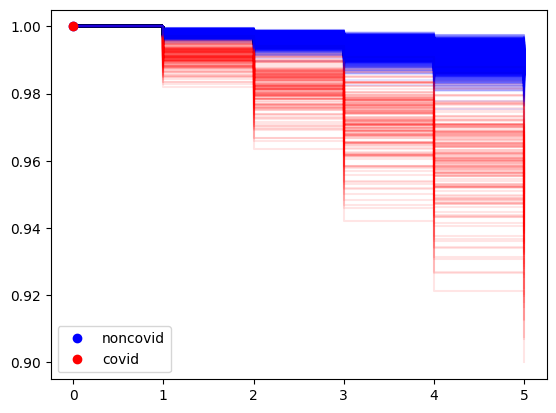

In [518]:
# Plot the posterior predictions
for r in np.arange(0, bart_sv_val.shape[0]):
    if smp_cov_msk[r] == 1:
        col = "red"
        lab="covid"
    else:
        col = "blue"
        lab="noncovid"
    plt.step(bart_sv_t, bart_sv_val[r,:], alpha=0.1, color=col, where="post")
plt.plot(0,1, "bo", label="noncovid")
plt.plot(0,1, "ro", label="covid")

# plt.step(bart_sv_t, , label="cov", where="post", color="black")
# plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post", color="black")
plt.legend()

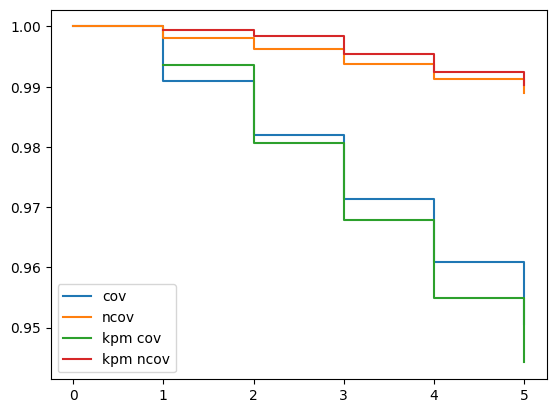

In [519]:
cov_mask = (x_mat[:,0]==1)
# kpm_adj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"], y_sk["Survival_in_days"])
kpm_cadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][cov_mask], y_sk["Survival_in_days"][cov_mask])
kpm_ncadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][~cov_mask], y_sk["Survival_in_days"][~cov_mask])

plt.step(bart_sv_t, bart_sv_val[smp_cov_msk].mean(0), label="cov", where="post")
plt.step(bart_sv_t, bart_sv_val[~smp_cov_msk].mean(0), label="ncov", where="post")
# plt.step(kpm_adj[0], kpm_adj[1], label="all", where="post")
plt.step(kpm_cadj[0], kpm_cadj[1], label="kpm cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="kpm ncov", where="post")


plt.legend()

In comparison to the KPM estimates, we can see the sample w/ case_cohort*5 does worse than the the case cohort model relative to comparison to the full KPM

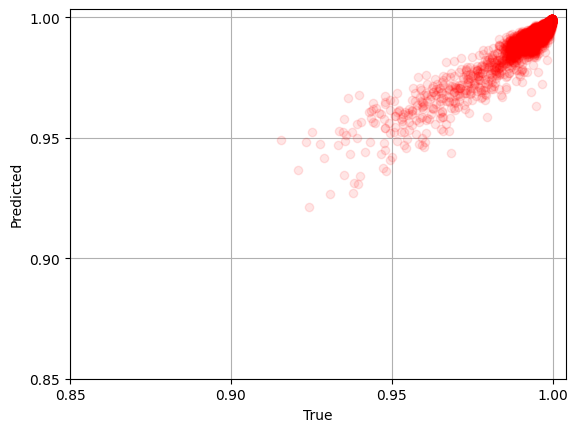

In [520]:
# get sv true
t_msk = np.array(np.arange(0,np.ceil(TT_ADJ/TT_SCALE) + 1) * TT_SCALE, dtype="int")
sv_true_t = sv_mat[:,t_msk]
sv_true_t = sv_true_t[smp_msk,:]
t_len = len(t_msk)


assert sv_true_t.shape ==  bart_sv_val.shape

for i in np.arange(0,sv_true_t.shape[0]):
    plt.plot(sv_true_t[i,1:-1],bart_sv_val[i,1:-1],"ro", alpha=0.1)
plt.ylabel("Predicted")
plt.xlabel("True")
plt.xticks(np.arange(0.85,1, 0.05))
plt.yticks(np.arange(0.85,1, 0.05))
plt.grid(visible="true")

Sample cohort TRUE=PRED plot is fairly decent

### TEST Sample Cohort

In [526]:
with bart:
    pm.set_data({"x":pd.DataFrame(te_b_te_x)}, coords= {"obs":np.arange(0,te_b_te_x.shape[0],1)})
    te_pp = pm.sample_posterior_predictive(bdata, var_names=["mu"])

te_bart_sv_val, te_bart_sv_t = get_sv_wrap(te_y_sk, te_b_tr_t, te_pp)

Sampling: [f]


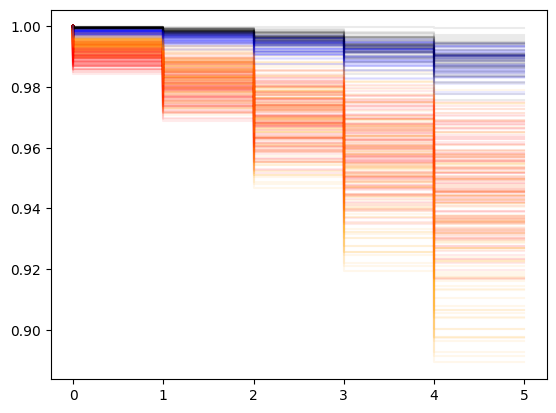

In [527]:
te_cov_msk = np.array(te_x_sk.iloc[:,0]==1)
for i in np.arange(0, te_bart_sv_val.shape[0]):
    if te_cov_msk[i]:
        col="red"
        col2 = "orange"
    else:
        col = "blue"
        col2 = "black"
    plt.step(te_bart_sv_t, te_bart_sv_val[i,:], color=col, alpha=0.08)
    plt.step(te_bart_sv_t, te_sv_f[i,:], color=col2, alpha=0.08)

In [528]:
p_c95 = np.quantile(te_bart_sv_val[te_cov_mask,:], [0.0275,0.975], axis=0)
p_nc95 = np.quantile(te_bart_sv_val[~te_cov_mask,:], [0.0275,0.975], axis=0)
t_c95 = np.quantile(te_sv_f[te_cov_mask,:], [0.0275,0.975], axis=0)
t_nc95 = np.quantile(te_sv_f[~te_cov_mask,:], [0.0275,0.975], axis=0)

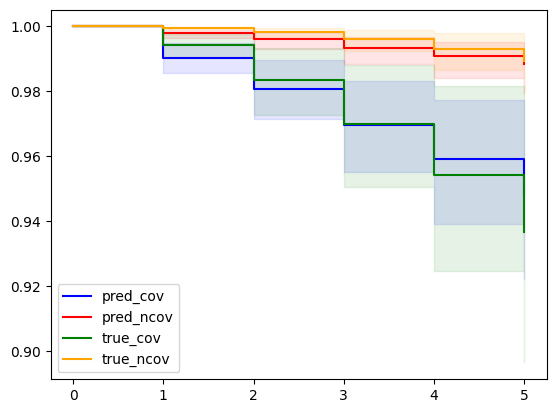

In [529]:
te_cov_msk = np.array(te_x_sk.iloc[:,0]==1)
plt.step(te_bart_sv_t, te_bart_sv_val[te_cov_msk,:].mean(0), label = "pred_cov", where="post", color="blue")
plt.fill_between(te_bart_sv_t, y1=p_c95[0,:], y2 = p_c95[1,:], step="post", alpha=0.1, color="blue")

plt.step(te_bart_sv_t, te_bart_sv_val[~te_cov_msk,:].mean(0), label = "pred_ncov", color="red", where="post")
plt.fill_between(te_bart_sv_t, y1=p_nc95[0,:], y2 = p_nc95[1,:], step="post", alpha=0.1, color="red")

plt.step(te_bart_sv_t, te_sv_f[te_cov_msk,:].mean(0), label = "true_cov", color="green", where="post")
plt.fill_between(te_bart_sv_t, y1=t_c95[0,:], y2 = t_c95[1,:], step="post", alpha=0.1, color="green")

plt.step(te_bart_sv_t, te_sv_f[~te_cov_msk,:].mean(0), label = "true_ncov", color="orange", where="post")
plt.fill_between(te_bart_sv_t, y1=t_nc95[0,:], y2 = t_nc95[1,:], step="post", alpha=0.1, color="orange")
plt.legend()

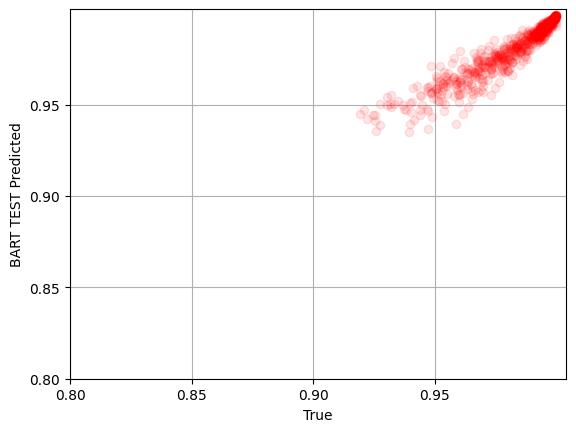

In [530]:
for i in np.arange(0,te_sv_f.shape[0]):
    plt.plot(te_sv_f[i,1:-1],te_bart_sv_val[i, 1:-1], "ro", alpha=0.1)
    # plt.plot(bart_sv_val[i,1:-1], cph_sv_val[i,1:-1],"bo", alpha=0.1)

plt.ylabel("BART TEST Predicted")
plt.xlabel("True")
plt.xticks(np.arange(0.80,1, 0.05))
plt.yticks(np.arange(0.80,1, 0.05))
plt.grid(visible=True)

In [531]:
# Cindex
shp1,shp2,shp3 = te_pp.posterior_predictive["mu"].values.shape
shp4 = te_x_sk.shape[0]
shp5 = np.unique(te_b_tr_t).shape[0]

bart_hz1 = te_pp.posterior_predictive["mu"].values.reshape(shp1*shp2, shp3).mean(axis=0).reshape(shp4,shp5)
bart_chz1 = np.cumsum(bart_hz1, axis=1)
cph_chz = cph.predict_cumulative_hazard_function(te_x_sk)
cph_chz = np.array([fn(fn.x) for fn in cph_chz])

for i in np.arange(bart_hz1.shape[1]):
    ci = concordance_index_censored(te_y_sk["Status"], te_y_sk["Survival_in_days"], bart_hz1[:,i])
    print(f"bart cindex {i}: {ci}")

for i in np.arange(cph_chz.shape[1]):
    ci = concordance_index_censored(te_y_sk["Status"], te_y_sk["Survival_in_days"], cph_chz[:,i])
    print(f"cph cindex {i}: {ci}")


bart cindex 0: (0.6651400575141122, 6245, 3144, 0, 2000)
bart cindex 1: (0.6667376717435297, 6260, 3129, 0, 2000)
bart cindex 2: (0.6646075194376397, 6240, 3149, 0, 2000)
bart cindex 3: (0.6625838747470444, 6221, 3168, 0, 2000)
bart cindex 4: (0.661199275748216, 6208, 3181, 0, 2000)
cph cindex 0: (0.6722760677388433, 6312, 3077, 0, 2000)
cph cindex 1: (0.6722760677388433, 6312, 3077, 0, 2000)
cph cindex 2: (0.6722760677388433, 6312, 3077, 0, 2000)
cph cindex 3: (0.6722760677388433, 6312, 3077, 0, 2000)
cph cindex 4: (0.6722760677388433, 6312, 3077, 0, 2000)


In [547]:
# baseline c-index
te_chf = -np.log(te_sv_f)
# te_chf = -te_sv_f

for i in np.arange(1,te_chf.shape[1]):
    ci = concordance_index_censored(te_y_sk["Status"], te_y_sk["Survival_in_days"], te_chf[:,i])
    print(f"cph cindex {i}: {ci}")

cph cindex 1: (0.6619448290552774, 6215, 3174, 0, 2000)
cph cindex 2: (0.6619448290552774, 6215, 3174, 0, 2000)
cph cindex 3: (0.6619448290552774, 6215, 3174, 0, 2000)
cph cindex 4: (0.6619448290552774, 6215, 3174, 0, 2000)
cph cindex 5: (0.6619448290552774, 6215, 3174, 0, 2000)


The c-index is comparable between the SAMPLE, CASE:COHORT and CPH
Interestingly, the c-index based on the true SV values converted to Cumalative Hazard evaluates to a similar value to the other trained values. 
This highlights the lack of discernability that the C-index provides. If the population does not seperate very distinctly the C-index is not strong.

### SUMMARY
1. Decreasing the number of trees increases the out of sample performance. 


# Expected Value Comparison

Predicted distribution of the training dataset 


## Plot true vs predicted SV probs

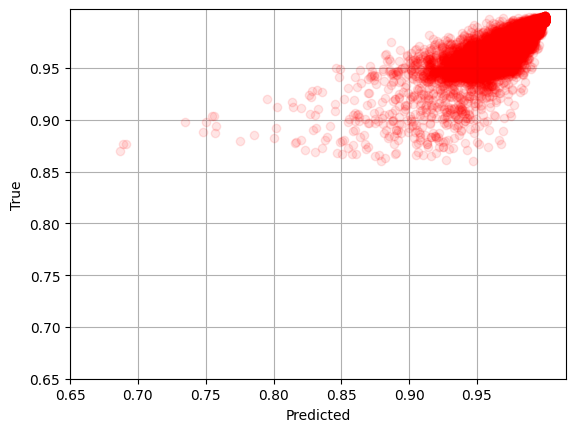

In [247]:
# get sv true
t_msk = np.array(np.arange(0,np.ceil(TT_ADJ/TT_SCALE) + 1) * TT_SCALE, dtype="int")
sv_true_t = sv_mat[:,t_msk]
t_len = len(t_msk)

assert sv_true_t.shape ==  bart_sv_val.shape

for i in np.arange(0,sv_true_t.shape[0]):
    plt.plot(bart_sv_val[i,1:-1], sv_true_t[i,1:-1],"ro", alpha=0.1)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(0.65,1, 0.05))
plt.yticks(np.arange(0.65,1, 0.05))
plt.grid(visible="true")

1-1 plot indicates generally the predictions follow the Expected SV values. There is possibly a slight downward biasis in the predicted values, but this might be due to the underlying sample rather than a poorly trained model.

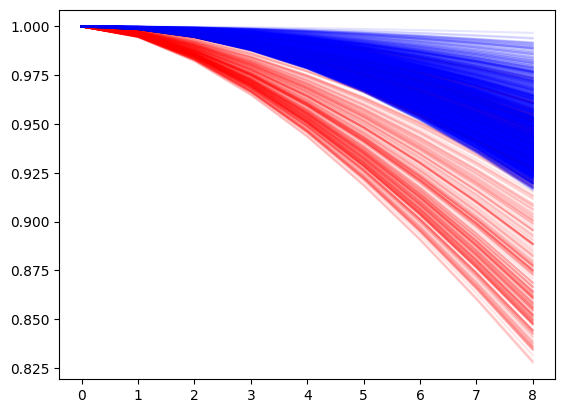

In [257]:

for i in np.arange(0,sv_true_t.shape[0]):
    if x_mat[i,0] == 1:
        col = "red"
        lab="covid"
    else:
        col = "blue"
        lab="noncovid"
    plt.plot(bart_sv_t, sv_true_t[i,:], color = col, alpha=0.1)

Looking at the true SV plot scaled and cropped we can see that we would expect a few patients to have a reduced sv value to ~0.82, the 

# COX
- Check how the COX model performs

In [237]:
# check cph
cph = sks.linear_model.CoxPHSurvivalAnalysis().fit(x_sk, y_sk)
print(f"exp coef: {np.exp(cph.coef_)}")

cph_sv = cph.predict_survival_function(x_sk)
cph_sv = np.array([fx(fx.x) for fx in cph_sv])

# we can reuse val_fill from above
cph_sv_val = np.hstack([val_fill, cph_sv])

# cph_sv_val=np.hstack([np.repeat(1,cph_sv.shape[0]).reshape((cph_sv.shape[0],1)), cph_sv])

exp coef: [2.40077152 1.0075705  0.84494021 1.91174373 1.10660659 0.67167219
 1.04169248 0.90086605 1.51793181 0.85666355]


- The exp coef (HR) seems to indicate some spurious associations generated from the data. The exp coef shouldn't be interpreted as direct HR since we know that the DGP includes complex nonlinear and non-proportional hz. 
- The last 5 variables, which should all be near 1, seem to be not estimated correctly, with var 9 being a large HR.

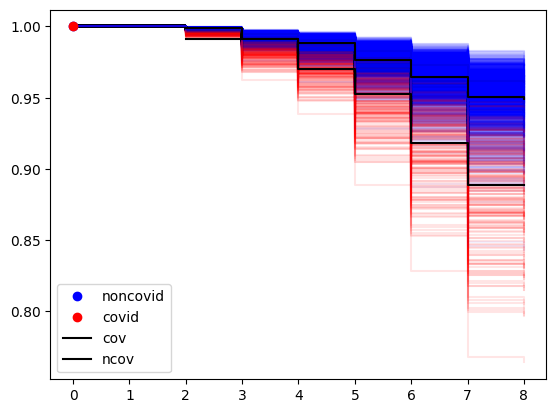

In [238]:
# cph_sv2 = np.hstack([np.repeat(1,cph_sv.shape[0]).reshape(cph_sv.shape[0],1), cph_sv[:, :]])
for i in np.arange(0, cph_sv_val.shape[0]):
    if x_mat[i,0] == 1:
        col = "red"
        alp = 0.1
    else:
        col = "blue"
        alp = 0.05
    plt.step(bart_sv_t, cph_sv_val[i,:], color=col, alpha=alp, where="post")
plt.plot(0,1, "bo", label="noncovid")
plt.plot(0,1, "ro", label="covid")
plt.step(kpm_cadj[0], kpm_cadj[1], label="cov", where="post", color="black")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post", color="black")
plt.legend()
# sv_true_t

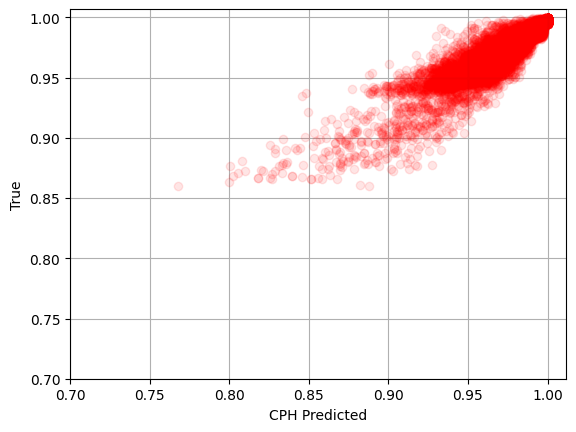

In [242]:
assert sv_true_t.shape ==  bart_sv_val.shape

for i in np.arange(0,sv_true_t.shape[0]):
    plt.plot(cph_sv_val[i, 1:-1], sv_true_t[i,1:-1],"ro", alpha=0.1)
    # plt.plot(bart_sv_val[i,1:-1], cph_sv_val[i,1:-1],"bo", alpha=0.1)

plt.xlabel("CPH Predicted")
plt.ylabel("True")
plt.xticks(np.arange(0.7,1, 0.05))
plt.yticks(np.arange(0.7,1, 0.05))
plt.grid(visible=True)

- Similar to the bart plot the predicted tend to be biased lower than the the Expected by the GDP. I would assume this has more to do with the random draw of the data more than the ability to fit the model

Text(0, 0.5, 'cph')

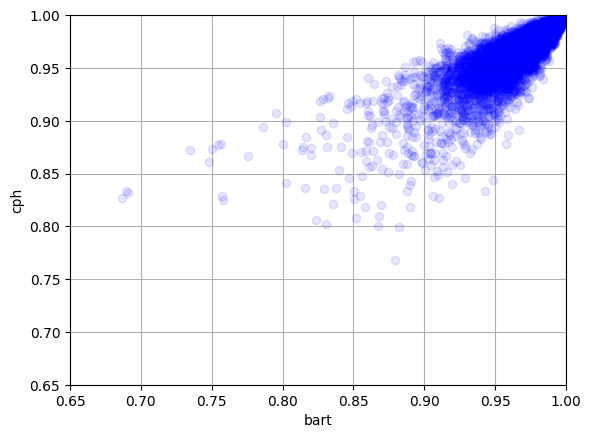

In [252]:
assert cph_sv_val.shape ==  bart_sv_val.shape

for i in np.arange(0,sv_true_t.shape[0]):
    # plt.plot(cph_sv_val[i, 1:-1], sv_true_t[i,1:-1],"ro", alpha=0.1)
    plt.plot(bart_sv_val[i,1:-1], cph_sv_val[i,1:-1],"bo", alpha=0.1)
plt.grid(visible=True)
plt.xlim(.65,1)
plt.ylim(.65,1)
plt.xlabel("bart")
plt.ylabel("cph")

The comparison of bart and cox predictions demonstrate BART has a few outliers that are decreased SV probability

# Metrics
- C-INDEX
- TD-AUC
- Brier Score

In [258]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

In [266]:
# set up hazards to use
shp1,shp2,shp3 = pp.posterior_predictive["mu"].values.shape
shp4 = x_sk.shape[0]
shp5 = np.unique(b_tr_t).shape[0]

bart_hz1 = pp.posterior_predictive["mu"].values.reshape(shp1*shp2, shp3).mean(axis=0).reshape(shp4,shp5)
bart_chz1 = np.cumsum(bart_hz1, axis=1)

cph_chz = cph.predict_cumulative_hazard_function(x_sk)
cph_chz = np.array([fn(fn.x) for fn in cph_chz])


In [267]:
# c-index at distinct times
for i in np.arange(chz1.shape[1]):
    ci = concordance_index_censored(y_sk["Status"], y_sk["Survival_in_days"], bart_hz1[:,i])
    print(f"bart cindex {i}: {ci}")

for i in np.arange(cph_chz.shape[1]):
    ci = concordance_index_censored(y_sk["Status"], y_sk["Survival_in_days"], cph_chz[:,i])
    print(f"cph cindex {i}: {ci}")


bart cindex 0: (0.8113612100041543, 181637, 42230, 0, 3768)
bart cindex 1: (0.816122965868127, 182703, 41164, 0, 3768)
bart cindex 2: (0.8153144500976026, 182522, 41345, 0, 3768)
bart cindex 3: (0.8169806179561973, 182895, 40972, 0, 3768)
bart cindex 4: (0.8137108193704298, 182163, 41704, 0, 3768)
bart cindex 5: (0.8111780655478477, 181596, 42271, 0, 3768)
bart cindex 6: (0.8103181799907981, 181403, 42463, 1, 3768)
cph cindex 0: (0.6246923396480947, 139847, 84018, 2, 3768)
cph cindex 1: (0.6246968065860533, 139849, 84018, 0, 3768)
cph cindex 2: (0.6246968065860533, 139849, 84018, 0, 3768)
cph cindex 3: (0.6246968065860533, 139849, 84018, 0, 3768)
cph cindex 4: (0.6246968065860533, 139849, 84018, 0, 3768)
cph cindex 5: (0.6246968065860533, 139849, 84018, 0, 3768)
cph cindex 6: (0.6246968065860533, 139849, 84018, 0, 3768)


C-index indicates that the bart model performs superior to CPH. 

# time-auc

In [316]:
dy8_msk = np.where(y_sk["Survival_in_days"] == 8)
# np.where(y_sk["Status"][dy8_msk[0]] == True)
y_skauc = y_sk.copy()
# y_skauc = y_skauc[~dy8_msk[0]]
# tmp_sk = y_skauc[0]
y_skauc[0]["Survival_in_days"] = 9
y_skauc[0]["Status"] = True
# tmp_sk = tmp_sk.reshape(1,)
# y_skauc = np.concatenate([y_skauc, tmp_sk])


In [294]:
cph_chz.shape
bart_hz1.shape
bart_sv_t

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [321]:

cph_cda = cumulative_dynamic_auc(
    survival_train=y_skauc, 
    survival_test=y_skauc, 
    estimate=cph_chz[:,:6], 
    times=bart_sv_t[2:8]
)

brt_cda = cumulative_dynamic_auc(
    survival_train=y_skauc, 
    survival_test=y_skauc, 
    estimate=bart_hz1[:,:6], 
    times=bart_sv_t[2:8]
)

print(f"BART: {brt_cda}")
print(f"CPH: {cph_cda}")

BART: (array([0.9127004 , 0.83687817, 0.84578745, 0.81411902, 0.8012602 ,
       0.81778479]), 0.8208741710771652)
CPH: (array([0.64003006, 0.55854172, 0.61934946, 0.61679632, 0.61771663,
       0.62659764]), 0.614208261428285)


# Integrated Brier score

In [25]:
# bart_sv_brier = ssf.get_sv_fx(pp, x_sk)

In [330]:
cph_sv2 = np.hstack([np.repeat(1,cph_sv.shape[0]).reshape(cph_sv.shape[0],1), cph_sv[:, :]])
bart_ibs = integrated_brier_score(y_sk, y_sk, bart_sv_val[:, 6:8], bart_sv_t[6:8])
cph_ibs = integrated_brier_score(y_sk, y_sk, cph_sv_val[:, 6:8], bart_sv_t[6:8])

print(f"bart brier: {bart_ibs}")
print(f"cph brier: {cph_ibs}")

bart brier: 0.043345967021582874
cph brier: 0.045859387588214


- BART is better across all 3 metrics. In both C-index and AUC bart performes significantly better. In Brier Score Bart only performs slightly better, but this is to be expected, since the variance of sv times is relatively small and both models deviate little from the KPM estimate.
- Of note the AUC is calculated by switching one censored obs at the max time to True and 1 + max. This would adjust the AUC slightly at this time point, which is why we don't report AUC for the last tp
    - The adjust to AUC is minimal.

 

## RMSE and BIAS

In [331]:
def get_metrics(f_t, f, times, quants = np.array([0.1, 0.25, 0.5, 0.75, 0.9])):
    f_t = np.matrix(f_t)[:,times]
    f = np.matrix(f)[:, times]

    rmse = np.round(np.sqrt(np.mean(np.power(f_t - f, 2), axis=0)), 4)
    bias = np.round(np.mean(f_t - f, axis = 0), 4)
    
    return rmse, bias


In [332]:
bart_met =  get_metrics(sv_true_t, bart_sv_val, times = [2,3,4,5,6,7,8])
cph_met = get_metrics(sv_true_t, cph_sv_val, times = [2,3,4,5,6,7,8])


print(f"BART RMSE: {bart_met[0]}")
print(f"CPH RMSE: {cph_met[0]}")
print(f"BART BIAS: {bart_met[1]}")
print(f"CPH BIAS: {cph_met[1]}")


BART RMSE: [[0.003  0.0054 0.0087 0.0131 0.0191 0.0246 0.0277]]
CPH RMSE: [[0.0036 0.0039 0.0065 0.0082 0.0125 0.0178 0.0186]]
BART BIAS: [[-0.0016 -0.0014 -0.0021 -0.0002  0.003   0.0035 -0.0067]]
CPH BIAS: [[-0.0026 -0.0015 -0.0033 -0.0005  0.0035  0.0069 -0.0062]]


- RMSE and BIAS are minimal for both models. This would be assumed to be due to the relatively high SV probability displayed at the end timepoints

# BART VAR EVAL
- Use PDP to evaluate variables
- Compare to the True difference expected from the model

In [ ]:
pp

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

/home/twj8/.local/lib/python3.10/site-packages/pymc_bart/utils.py:778: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  chains_hdi = az.hdi((var_imp_chains.T / var_imp_chains.sum(axis=1)).T)[indices]


(array([ 0, 10,  5,  2,  6,  8,  4,  1,  9,  3,  7]),
 array([<AxesSubplot:xlabel='covariables', ylabel='importance'>,
        <AxesSubplot:xlabel='number of covariables', ylabel='R²'>],
       dtype=object))

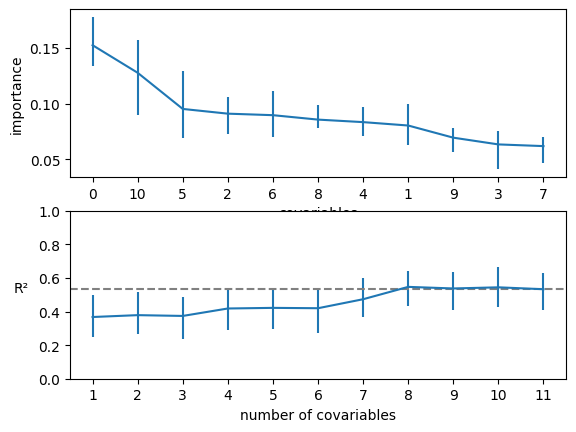

In [333]:
pmb.plot_variable_importance(
    idata=bdata,
    bartrv=f,
    X=b_tr_x,
    samples=300
)

- Variable importance doesn't seem to apply very well to this model
- Use PDPs for better evaluation
- We expect a small effect of COVID, larger effect of AGE and a combined effect of COVID and AGE. The other 3 variables should have a small effect, but may not be noticeable in this sample. The last 5 variables should have no effect



In [335]:
LAMBDA

'np.exp(-8.4 + 0.2*x_mat[:,0] + 0.2*np.log(x_mat[:,1]) + x_mat[:,0]*0.01*np.log(x_mat[:,1])  + 0.001*np.power(x_mat[:,2],2) + 0.09*(x_mat[:,3]*x_mat[:,4]))'

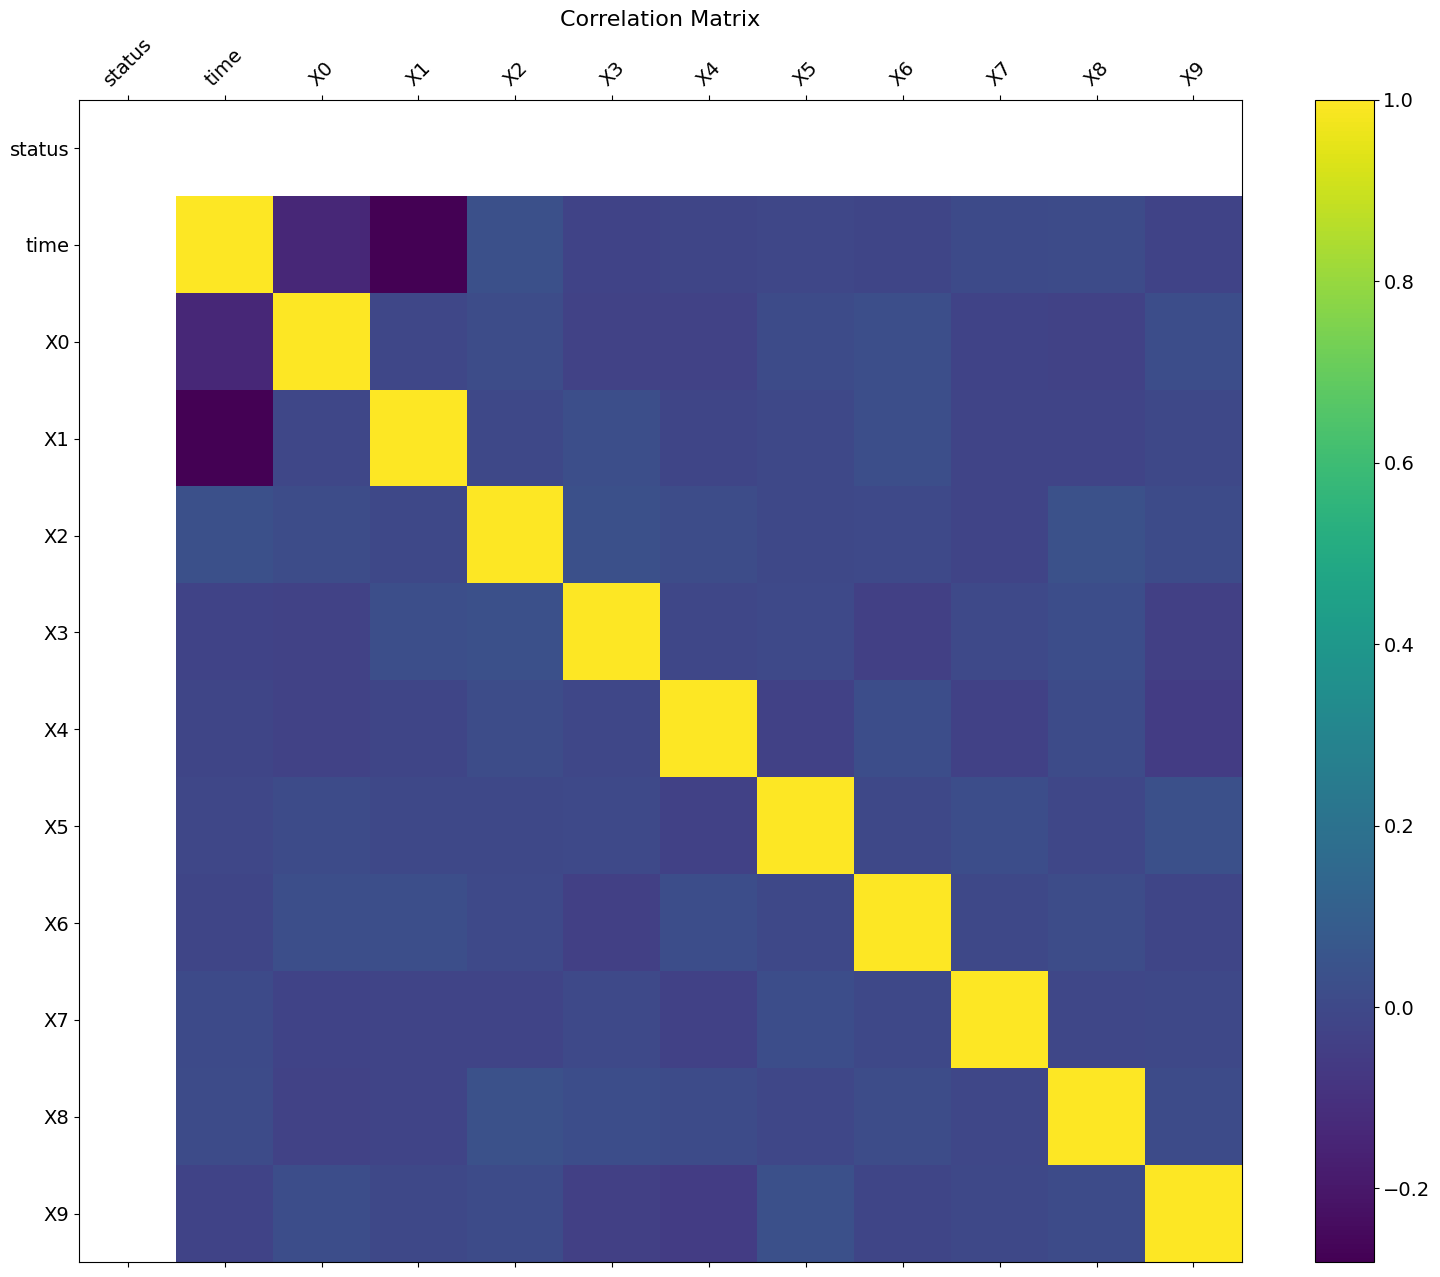

In [334]:
# Feature correlation plots
fm = plt.figure(figsize=(19, 15))
plt.matshow(train.corr(), fignum=fm.number)
plt.xticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(train.select_dtypes(['number']).shape[1]), train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

The correlation plot demonstrates relatively how associated each variable is with the event time

## PDP 

- Below is a PDP function to compute a pdp for a give variable (in the context of sv). This function sets up the data and a call to the BART model to return posterior predictive in following step.
- Since these are all continuous variables, it is required to specify the values to compute PDP on for the given var.


Functions

In [433]:
# fdps for each var taking high and low value

def get_pdp(dtst, VAR, TIMES, VAL=[0.25,0.5,0.75,], SAMPLE=False, RN=100):
    # get a mask for subset of obs
    p_idx = np.where(dtst[:,0] == TIMES)
    pdp = dtst[p_idx[0],:]
    t_val = TIMES[0]
    # sample 
    if SAMPLE:
        tmp = dtst[np.where(dtst[:,0]==t_val)[0],:]
        # print(tmp.shape)
        rn_idx = np.random.choice(np.arange(0,tmp.shape[0]), RN, replace=False)
        pdp = tmp[rn_idx,:]
        # pdp = np.vstack([pdp]*len(TIMES))
        pdp = np.repeat(pdp, len(TIMES), axis=0)
        # print(pdp)
        pdp[:,0] = np.asarray(np.tile(TIMES, RN)).reshape(RN*len(TIMES),1)
        
    # make the pdp dataset
    rep = len(VAL)
    pdp_stack = np.vstack([pdp]*rep)
    val = np.quantile(np.asarray(pdp[:,VAR]), VAL)
    pdp_stack[:,VAR] = np.repeat(val, pdp.shape[0]).reshape(pdp_stack.shape[0],1)
    
    if SAMPLE:
        # pdp_stack is the pdp dataset and pdp is just to return the size of a single iteration of the pdp for sv_fx generation
        return pdp_stack, int(pdp_stack.shape[0]/len(TIMES)), len(TIMES)
    return pdp_stack, int(pdp_stack.shape[0]/len(TIMES)), len(TIMES)

def get_sv_fx(pp, r0, r1):
    p0 = pp.posterior_predictive["mu"].values.shape[0]
    p1 = pp.posterior_predictive["mu"].values.shape[1]
    p2 = pp.posterior_predictive["mu"].values.shape[2]
    pp_post = pp.posterior_predictive["mu"].values.reshape(p0*p1, p2).mean(axis=0).reshape(r0, r1)
    sv = (1-pp_post).cumprod(axis=1)
    return sv

def svplot(sv, tpt, brkpnt, qnt=[0.0275, 0.975], val=None):
    # Plots the SV points for each and Variance
    # Baseline is always the first Value
    istrt = 0
    shift = -.05
    for idx, iend in enumerate(brkpnt):
        qtmp = np.quantile(sv[istrt:iend,], [qnt[0],qnt[1]], 0)
        ptmp = sv[istrt:iend,].mean(0)
        qtmp = np.abs(qtmp - ptmp)
        tpt2 = [xi+shift for xi in tpt]
        plt.errorbar(x=tpt2, y=ptmp, yerr = qtmp, fmt="o", alpha=0.3, label=f"Val:{val[idx]}", capsize=10)
        istrt = iend
        shift += 0.05
    plt.legend()


- Gets the pdp from a sample of the dataset

Sampling: [f, y_pred]


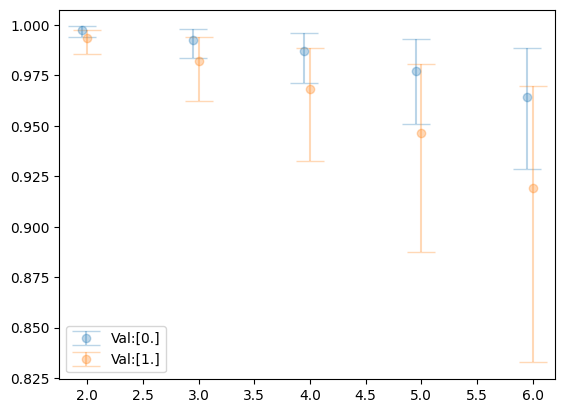

In [434]:
VAR=1
TIMES = [2,3,4,5,6]
RN = 500
VAL = [0,1]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

Compare to a sample of 1000 patients

Sampling: [f, y_pred]


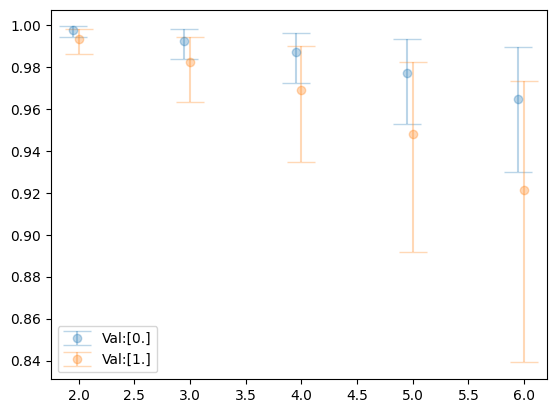

In [435]:
VAR=1
TIMES = [2,3,4,5,6]
RN = 1000
VAL = [0,1]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)# brk points is the number of patients in each set (could be automated)

- the larger sample doesn't make any significant changes too the plots

## Difference Between Exposures

In [436]:
def get_diff_avg(sv, BRKPNT):
    idx_refst = 0
    idx_refen = RN
    mean = []
    qt = []
    for idx,brk in enumerate(BRKPNT):
        diff = sv[brk:BRKPNT[idx+1]] - sv[idx_refst:idx_refen]
        d_mn = diff.mean(0)
        d_qt = np.quantile(diff, [0.0275, 0.975],0)
        # print(d_mn.shape)
        mean.append(d_mn)
        qt.append(d_qt)
        if BRKPNT[idx+1] == BRKPNT[-1]:
            break
    return mean, qt
# bart_sv_fx

def plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=None, TITLE=None):
    # ax,fig = plt.figure(diff_mn[0].shape[1])
    # color = ["ro","bo"]
    for idx, set in enumerate(diff_mn):
        print(set.shape)
        x = np.arange(0,set.shape[0])
        err = np.abs(diff_qt[0] - diff_mn[0])
        plt.errorbar(TIMES, set, yerr=err, alpha=0.3, fmt="o", label=f"diff {LABEL[idx]}")
    plt.legend()
    plt.title(f"Diff from Ref: {TITLE}")

def get_true_sv(lmbda, a=None, alpha_f=None, pdp_l=None, TIMES=None, scale=10):
    # if alpha_f is None:
    #     aaa = np.repeat(a, pdp_l.shape[0])
    # else:
    #     aaa = eval(alpha_f)
    ttt = np.array([t * scale for t in TIMES])
    msk = np.arange(0,pdp_l.shape[0],len(TIMES))
    # xxx = np.asarray(pdp_l[msk,1:])
    x_mat = np.asarray(pdp_l[msk,1:])
    if alpha_f is None:
        aaa = np.repeat(a, pdp_l.shape[0])
    else:
        aaa = eval(alpha_f)
    lll = eval(lmbda)
    s0 = int(pdp_l.shape[0]/len(TIMES))
    ooo = np.zeros((s0,len(TIMES)))
    # for idx, val in enumerate(ttt):
    #     pdp_true = np.exp(-1* np.power((lll*val), aaa))
    #     ooo[:,idx] = pdp_true
    for idx, l in enumerate(lll):
        pdp_true = np.exp(-1* np.power((l*ttt), aaa[idx]))
        ooo[idx,:] = pdp_true
    return ooo


def get_true_hz(lmbda, a=None, alpha_f=None, pdp_l=None, TIMES=None, scale=10):
    ttt = np.array([t * scale for t in TIMES])
    msk = np.arange(0,pdp_l.shape[0],len(TIMES))
    x_mat = np.asarray(pdp_l[msk,1:])
    if alpha_f is None:
        aaa = np.repeat(a, pdp_l.shape[0])
    else:
        aaa = eval(alpha_f)
    lll = eval(lmbda)
    s0 = int(pdp_l.shape[0]/len(TIMES))
    ooo = np.zeros((s0,len(TIMES)))
    # for idx, val in enumerate(ttt):
    #     pdp_true = np.exp(-1* np.power((lll*val), aaa))
    #     ooo[:,idx] = pdp_true
    for idx, l in enumerate(lll):
        pdp_true = np.exp(-1* np.power((l*ttt), aaa[idx]))
        ooo[idx,:] = pdp_true
    return ooo

(5,)


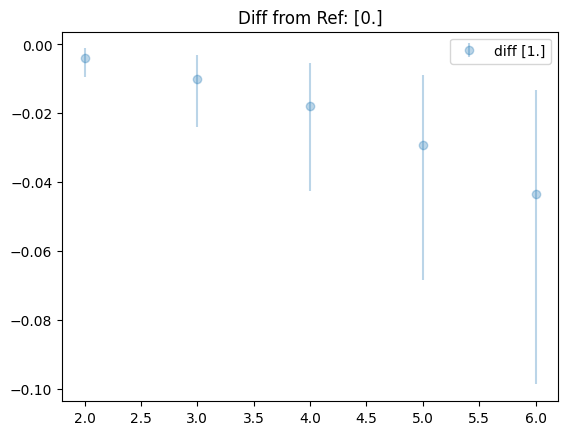

In [437]:
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals[1:], TITLE=vals[0])

Here we can see the measure of avg difference between the mean value across draws for each patient from the reference level and associated credible interval

By time 6 (1 year) there is an average predicted difference of -4% in SV probabilities. The 95% CI distribution of differences is between ~(-1%)-(-10%)    

Next get the expected difference. Plot the expected and predicted against each other for the marginal evaluations

In [438]:
# LAMBDA2 = "0.001 * np.exp(3+0.5*np.sin(np.pi*xxx[:,0]*xxx[:,1]) + np.power(xxx[:,2],2) + 0.5*xxx[:,3] + 0.25*xxx[:,4])" 
ooo = get_true_sv(lmbda = LAMBDA, alpha_f = ALPHA_F, pdp_l = pdp_l, TIMES=TIMES, scale=TT_SCALE)

array([[0.99711807, 0.99352733, 0.98852201, 0.98212364, 0.97435962],
       [0.99608563, 0.99121421, 0.98443422, 0.97578519, 0.96531728],
       [0.99799068, 0.9954847 , 0.9919869 , 0.98750778, 0.98206075],
       ...,
       [0.98442617, 0.96921199, 0.95028089, 0.92818501, 0.90338835],
       [0.99130991, 0.98276136, 0.97204071, 0.9594072 , 0.94506943],
       [0.99042559, 0.98101551, 0.96922624, 0.95535052, 0.93962557]])

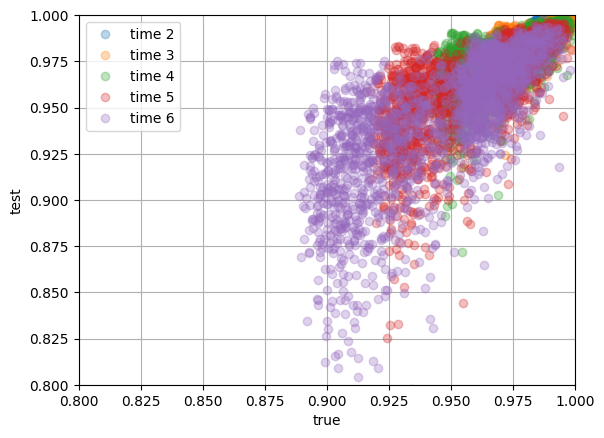

In [439]:
# check how the predictions compare
for i in np.arange(0,len(TIMES)):
    plt.plot(ooo[:,i], bart_sv_fx[:,i], "o", alpha=0.3, label = f"time {TIMES[i]}" )
plt.ylabel("test")
plt.xlabel("true")
plt.legend()
plt.xlim(0.8,1)
plt.ylim(0.8,1)
plt.grid(visible=True)


Predictions and True expectations align fairly well over the Time points values. 

There appears to be some bias in predictions to being slightly lower than expected. However the major proportion of predictions are within the body of the expected values.

The bias is most prevalent at the timepoint 6.

Plot the marginal difference plots and 95% CI distributions for the expected and predicted

(5,)
(5,)


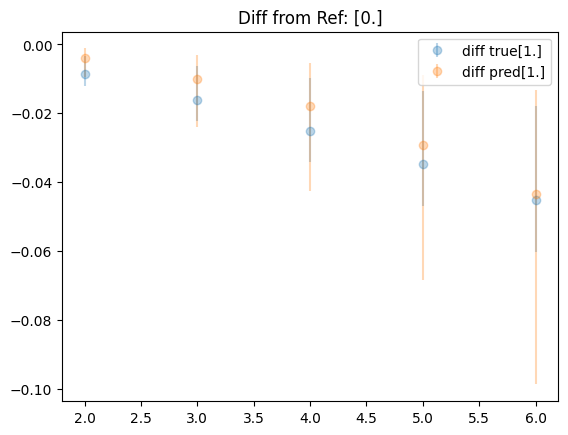

In [440]:
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

The expected and predicted mean marginal differnce is approximate to each other. The CI for the predicted outcomes is wider than the true interval, but the alignment of mean values is a positive sign.

With these results I think we can say that given similar Dataset conditions we can move forward with the method.

## Relative Risk Comparison

# Quick check the other variables

In [445]:
LAMBDA

'np.exp(-8.4 + 0.2*x_mat[:,0] + 0.2*np.log(x_mat[:,1]) + x_mat[:,0]*0.01*np.log(x_mat[:,1])  + 0.001*np.power(x_mat[:,2],2) + 0.09*(x_mat[:,3]*x_mat[:,4]))'

VAR 2

Sampling: [f, y_pred]


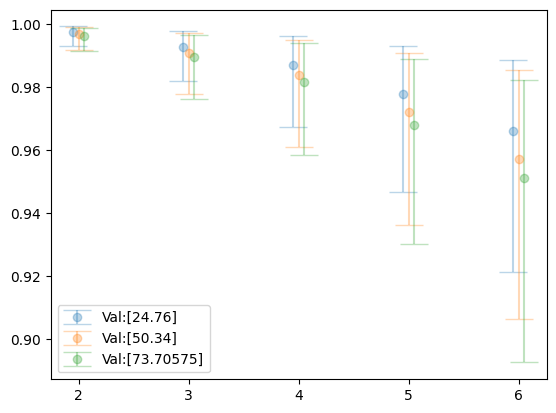

In [441]:
VAR=2
TIMES = [2,3,4,5,6]
RN = 400
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(5,)
(5,)
(5,)
(5,)


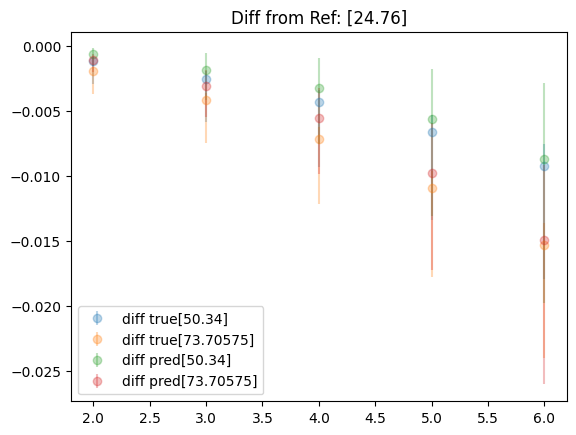

In [442]:
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
# plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals[1:], TITLE=vals[0])
ooo = get_true_sv(lmbda = LAMBDA, alpha_f = ALPHA_F, pdp_l = pdp_l, TIMES=TIMES, scale=TT_SCALE)
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Var 3

Sampling: [f, y_pred]


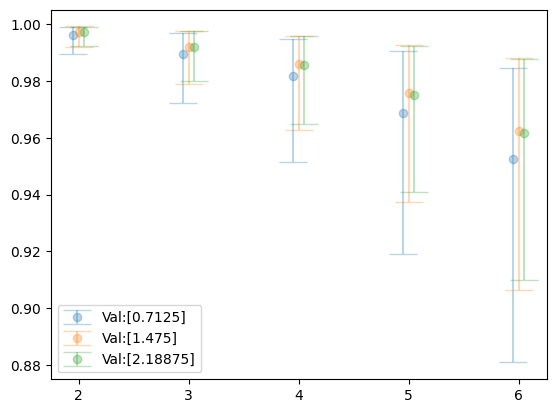

In [443]:
VAR=3
TIMES = [2,3,4,5,6]
RN = 400
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(5,)
(5,)
(5,)
(5,)


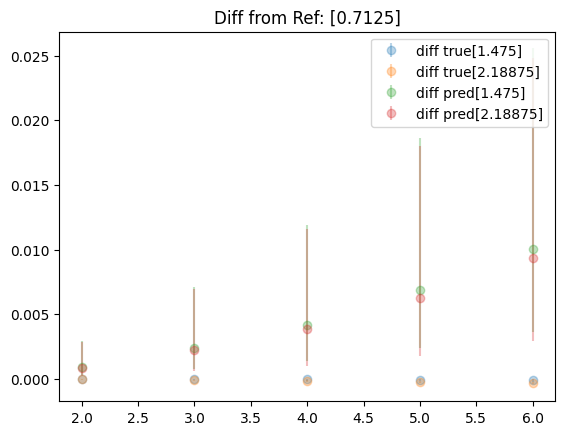

In [444]:
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
# plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals[1:], TITLE=vals[0])
ooo = get_true_sv(lmbda = LAMBDA, alpha_f = ALPHA_F, pdp_l = pdp_l, TIMES=TIMES, scale=TT_SCALE)
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Var 4

Sampling: [f, y_pred]


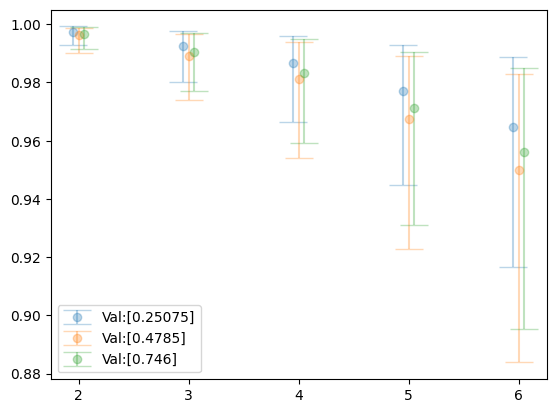

In [446]:
VAR=4
TIMES = [2,3,4,5,6]
RN = 1000
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(5,)
(5,)
(5,)
(5,)


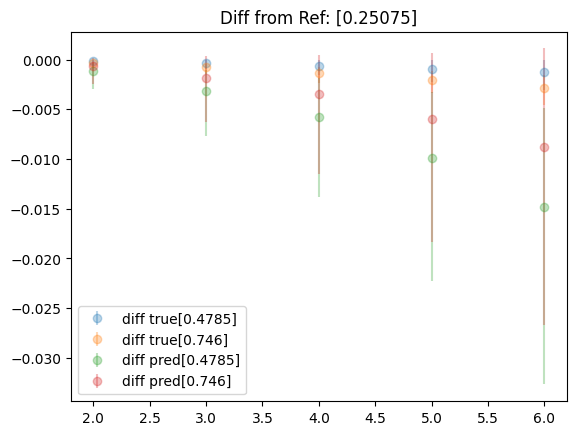

In [447]:
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
# plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals[1:], TITLE=vals[0])
ooo = get_true_sv(lmbda = LAMBDA, alpha_f = ALPHA_F, pdp_l = pdp_l, TIMES=TIMES, scale=TT_SCALE)
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Val 5

Sampling: [f, y_pred]


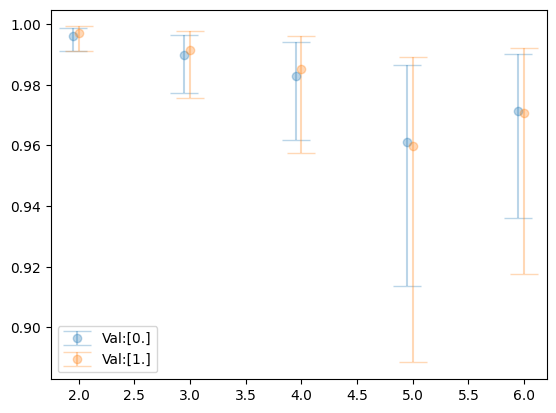

In [450]:
VAR=5
TIMES = [2,3,4,6,5]
RN = 400
VAL = [0, 1]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(5,)
(5,)


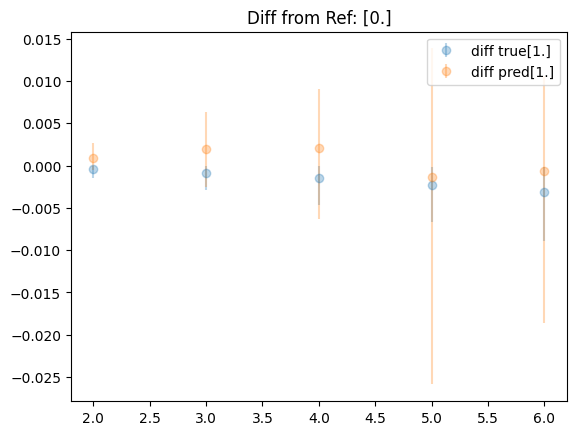

In [453]:
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
# plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals[1:], TITLE=vals[0])
ooo = get_true_sv(lmbda = LAMBDA, alpha_f = ALPHA_F, pdp_l = pdp_l, TIMES=TIMES, scale=TT_SCALE)
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Var 6

Sampling: [f, y_pred]


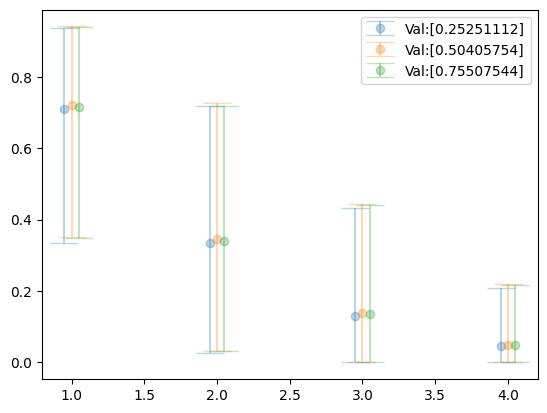

In [416]:
VAR=6
TIMES = [2,3,4,5,6]
RN = 400
VAL = [0.25, 0.5, 0.75]
SAMPLE = True
pdp_l, r0, r1 = get_pdp(b_te_x, VAR=VAR, TIMES=TIMES, VAL=VAL, SAMPLE=SAMPLE, RN=RN)
vals = np.unique(pdp_l[:,VAR],axis=0)
with bart:
    pm.set_data({"x":pd.DataFrame(pdp_l)}, coords= {"obs":np.arange(0,pdp_l.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# get the sv fx
bart_sv_fx = get_sv_fx(pp2, r0, r1)

# brk points is the number of patients in each set (could be automated)
BRKPNT = np.arange(RN,r0+1,RN)
svplot(bart_sv_fx, tpt=TIMES, brkpnt=BRKPNT, val=vals)

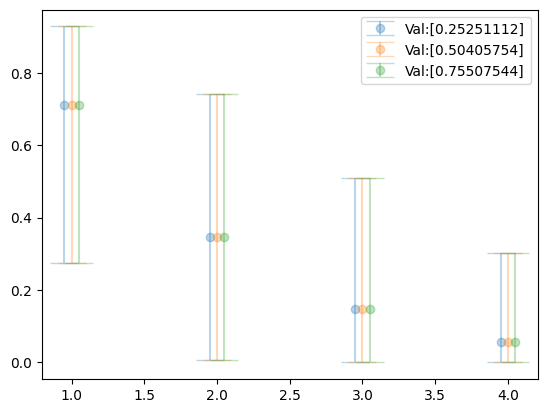

In [417]:
ooo = get_true_sv(lmbda = LAMBDA, a=2, pdp_l = pdp_l, TIMES=TIMES)
svplot(ooo, tpt=TIMES, brkpnt=BRKPNT, val=vals)

(4,)
(4,)
(4,)
(4,)


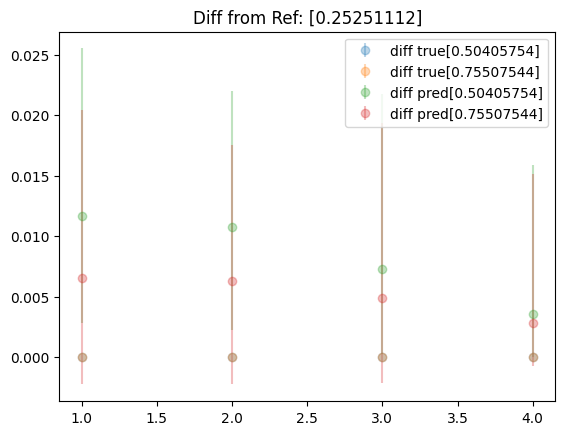

In [418]:
odiff_mn , odiff_qt = get_diff_avg(ooo, BRKPNT)
diff_mn , diff_qt = get_diff_avg(bart_sv_fx, BRKPNT)
vals2 = ["true"+str(v) for v in vals]
vals3 = ["pred"+str(v) for v in vals]
plt_diff_avg(odiff_mn, odiff_qt, TIMES, LABEL=vals2[1:], TITLE=vals[0])
plt_diff_avg(diff_mn, diff_qt, TIMES, LABEL=vals3[1:], TITLE=vals[0])

Var 6 in not incorporated into the DGP and its difference should be 0. The observed difference is less at most ~0.01, indicaating that the model did a fairly good job in not producing a high difference value on this valiable.